In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline
%config InlineBackend.figure_format = "retina"


register_matplotlib_converters()
sns.set(style = "whitegrid", palette = "muted", font_scale = 1.5)

rcParams["figure.figsize"] = 22, 10

In [3]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [4]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["z_axis"] = df["z_axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

<ipython-input-4-56736d26e660>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


(1098204, 6)


In [5]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098200,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,4
1098201,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,4
1098202,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,4
1098203,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,4


<Axes: xlabel='activity', ylabel='count'>

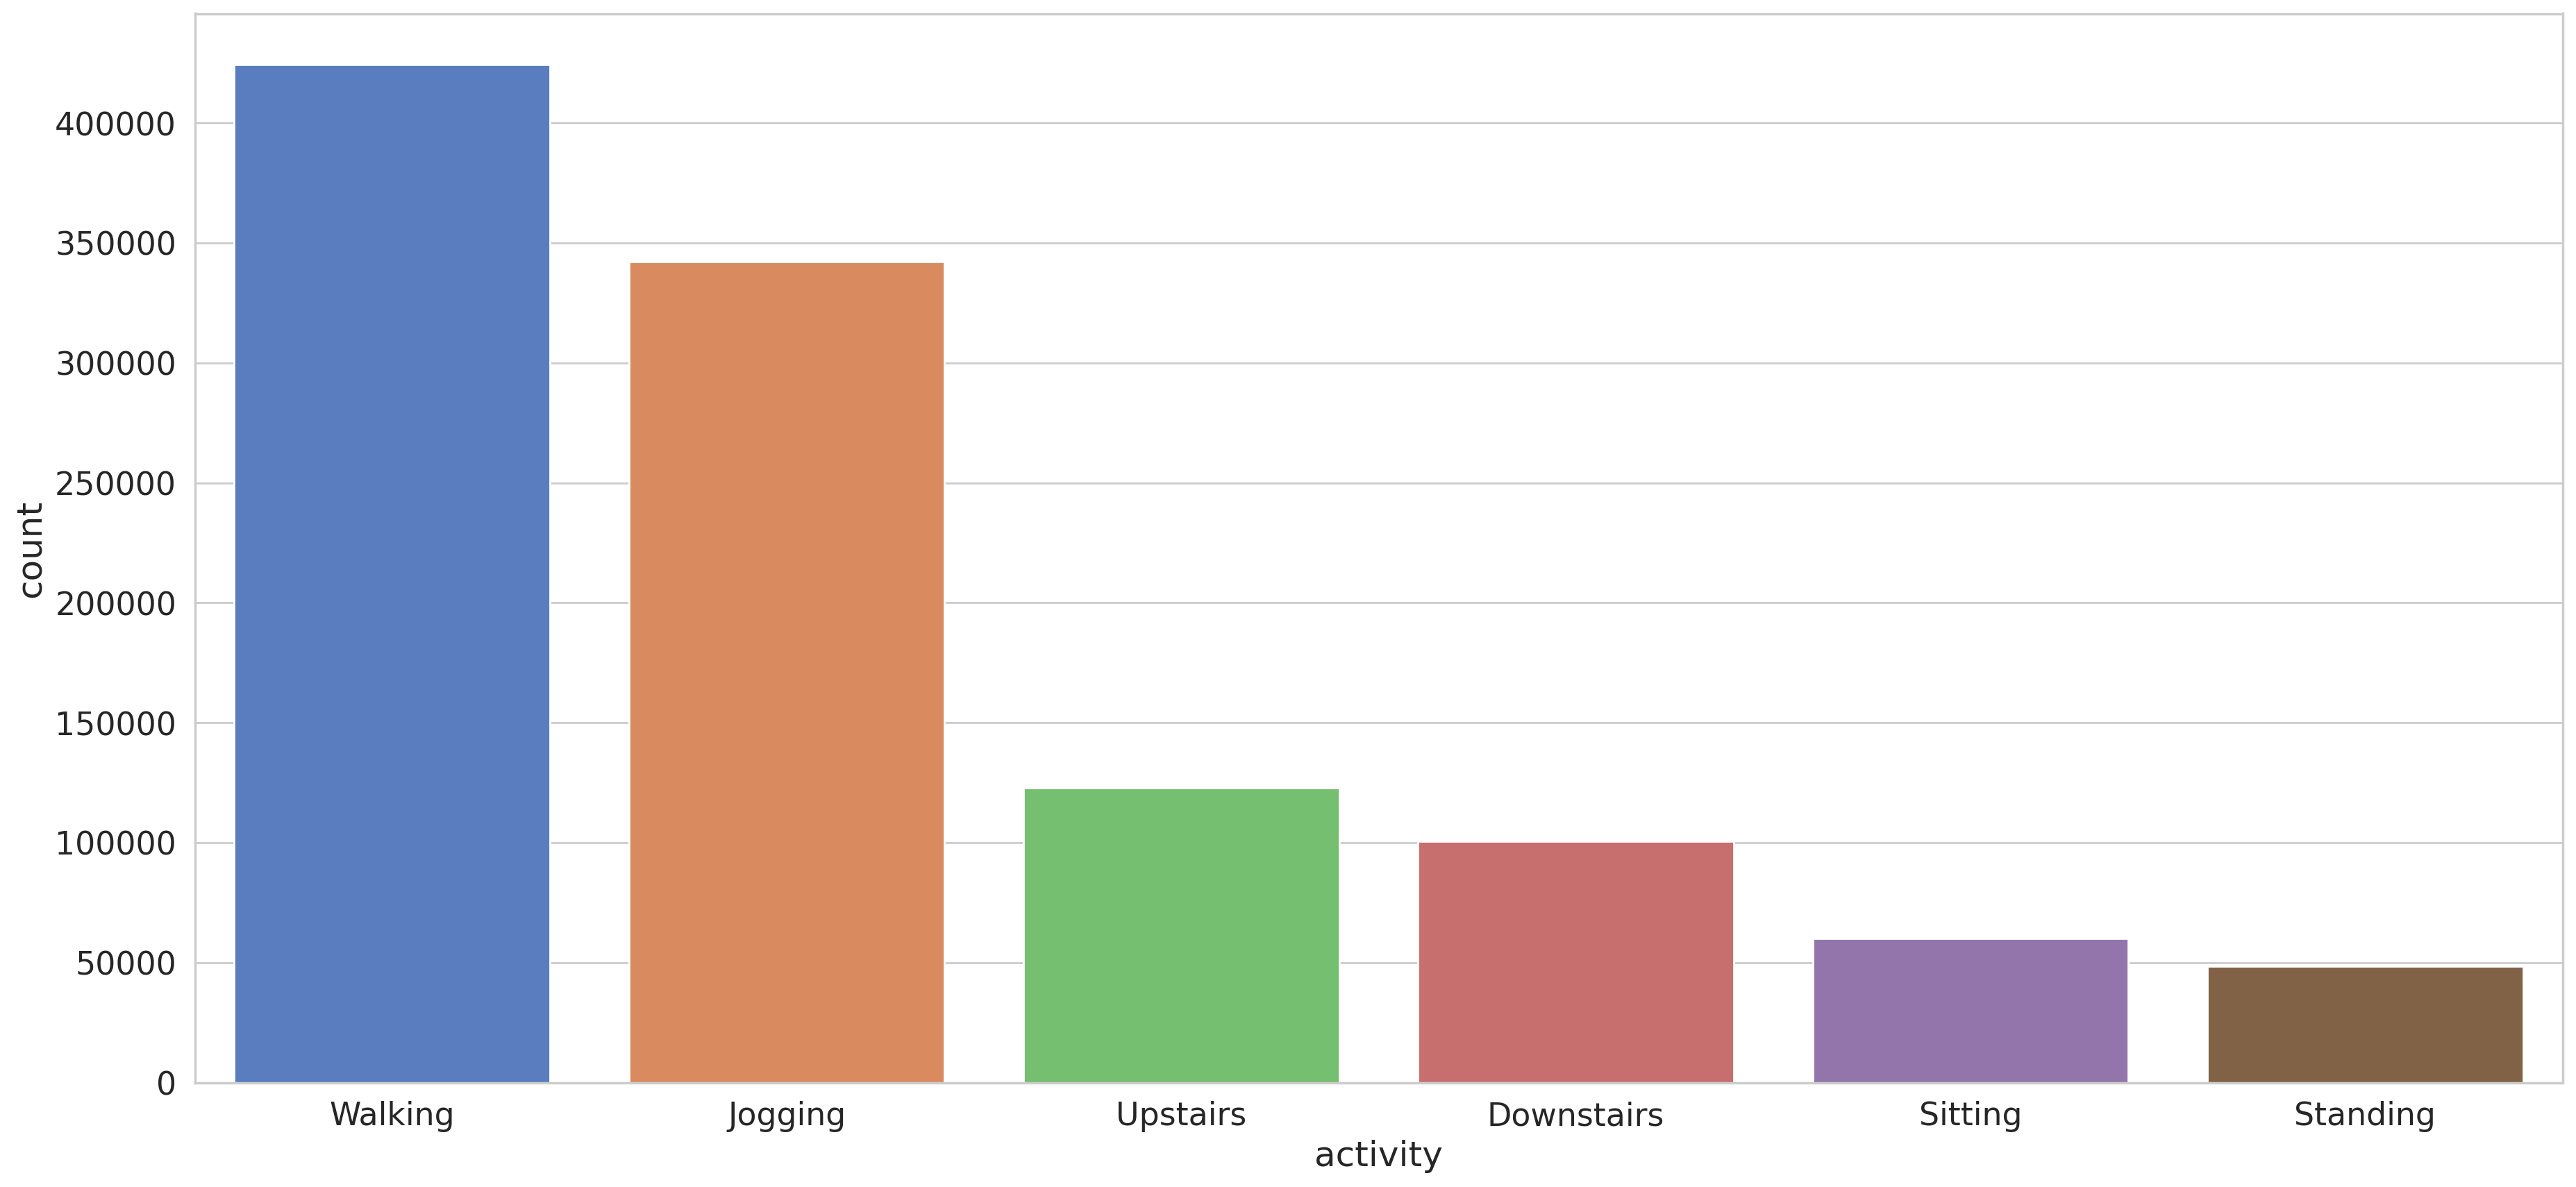

In [6]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

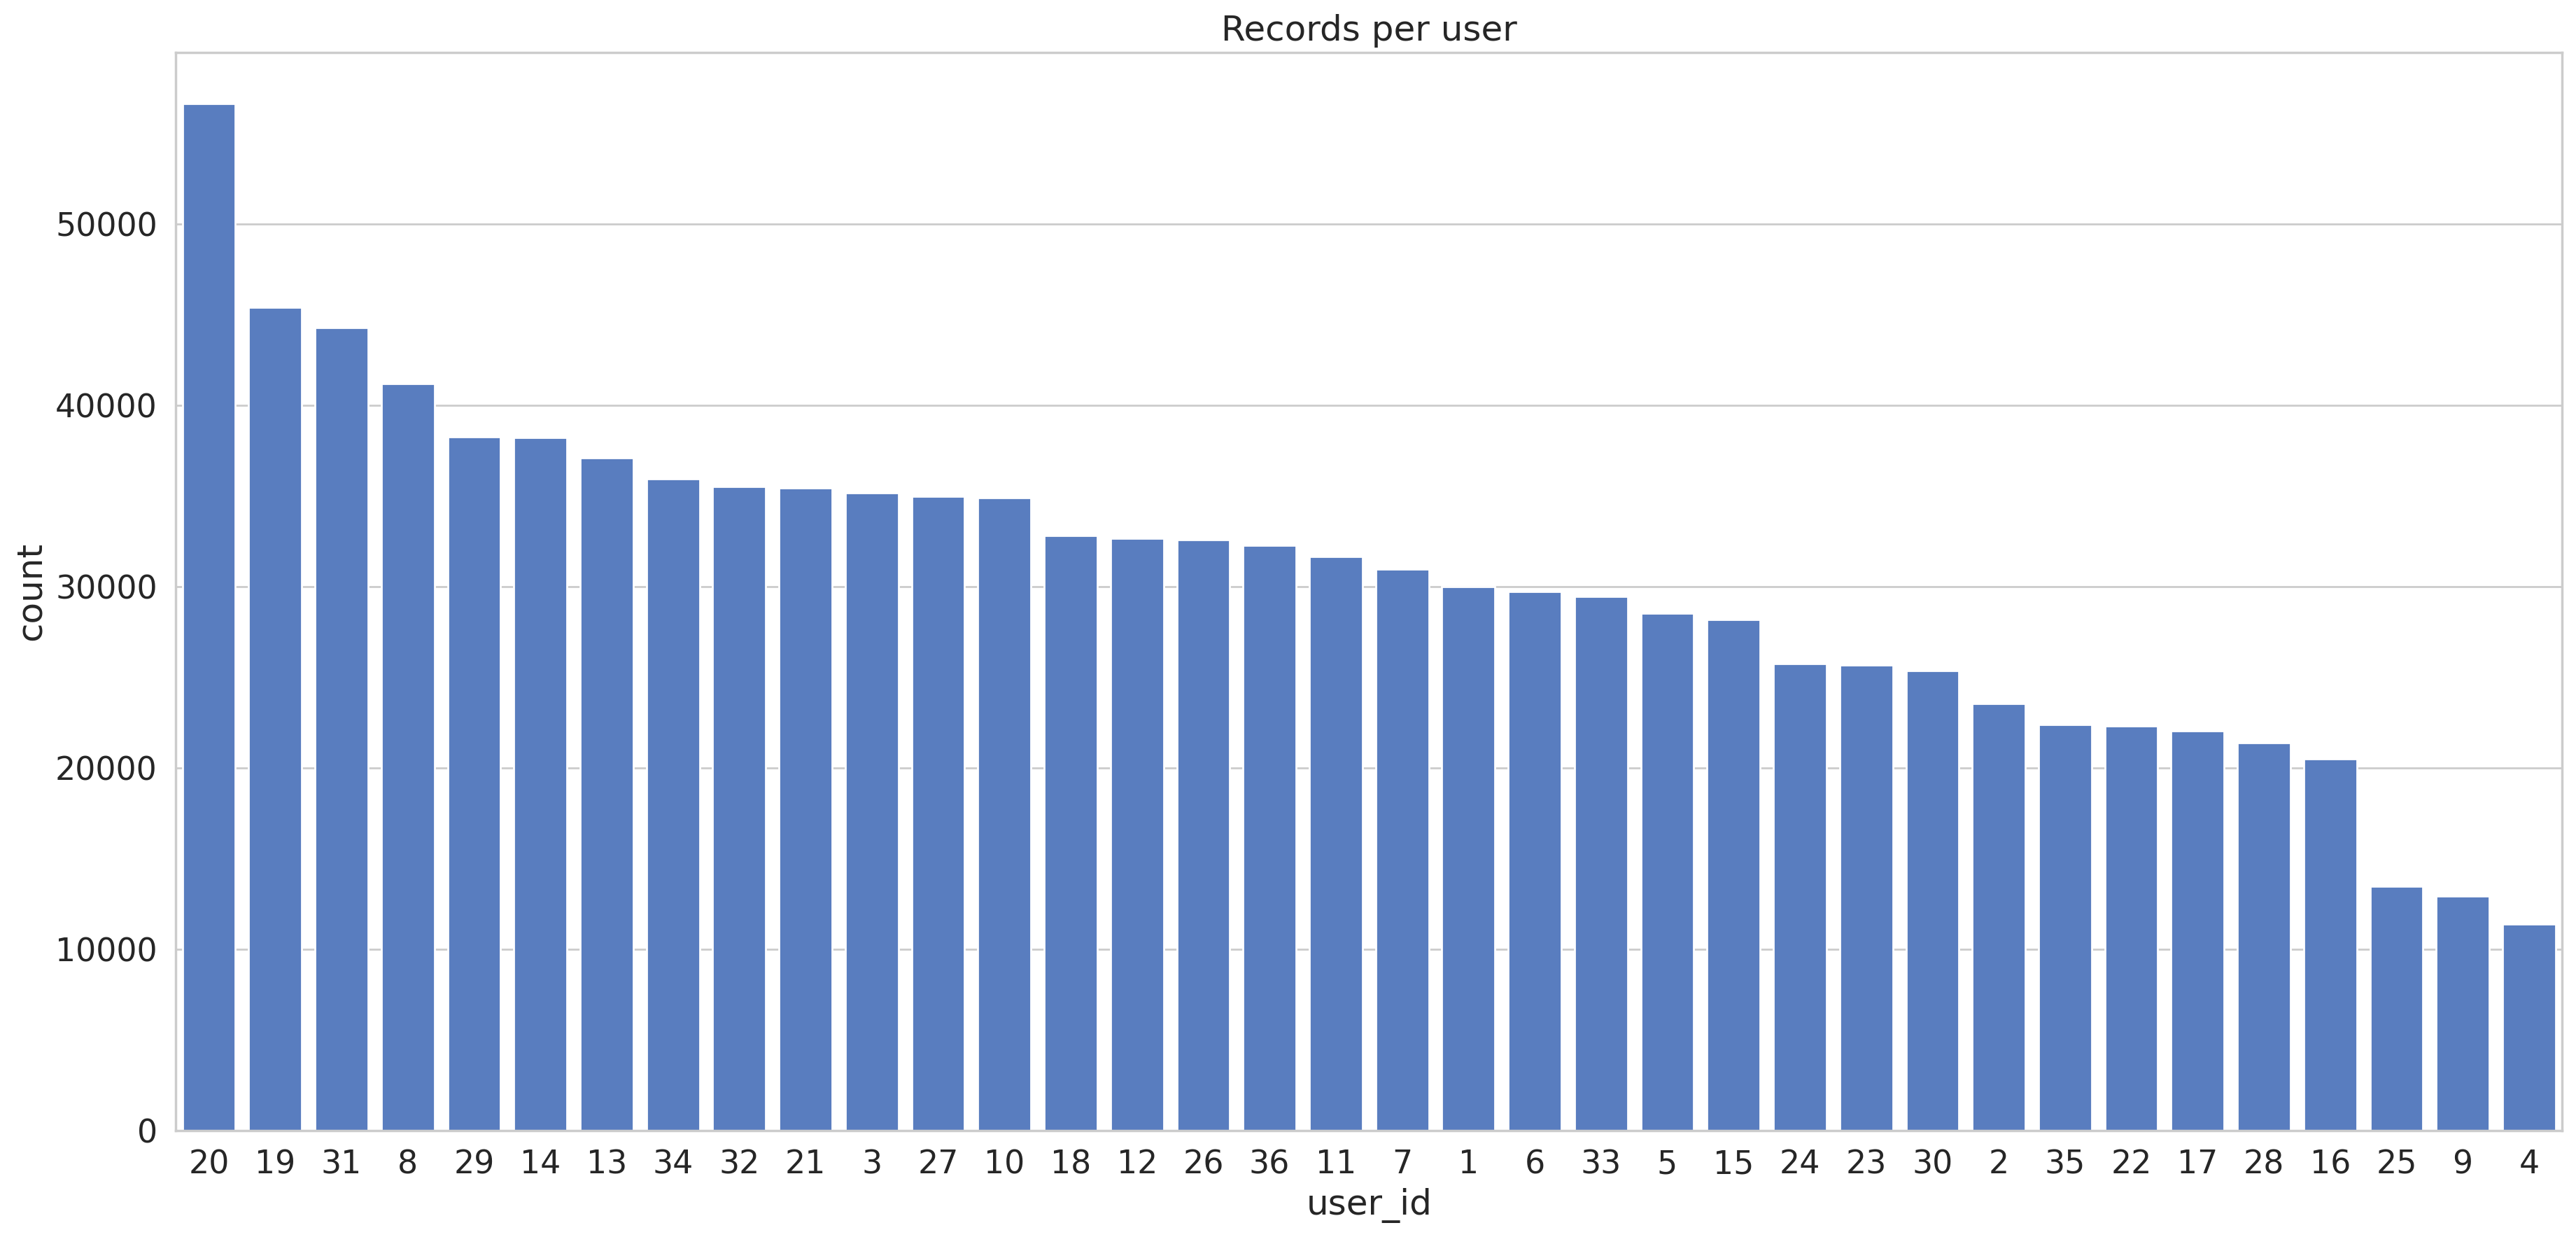

In [7]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");


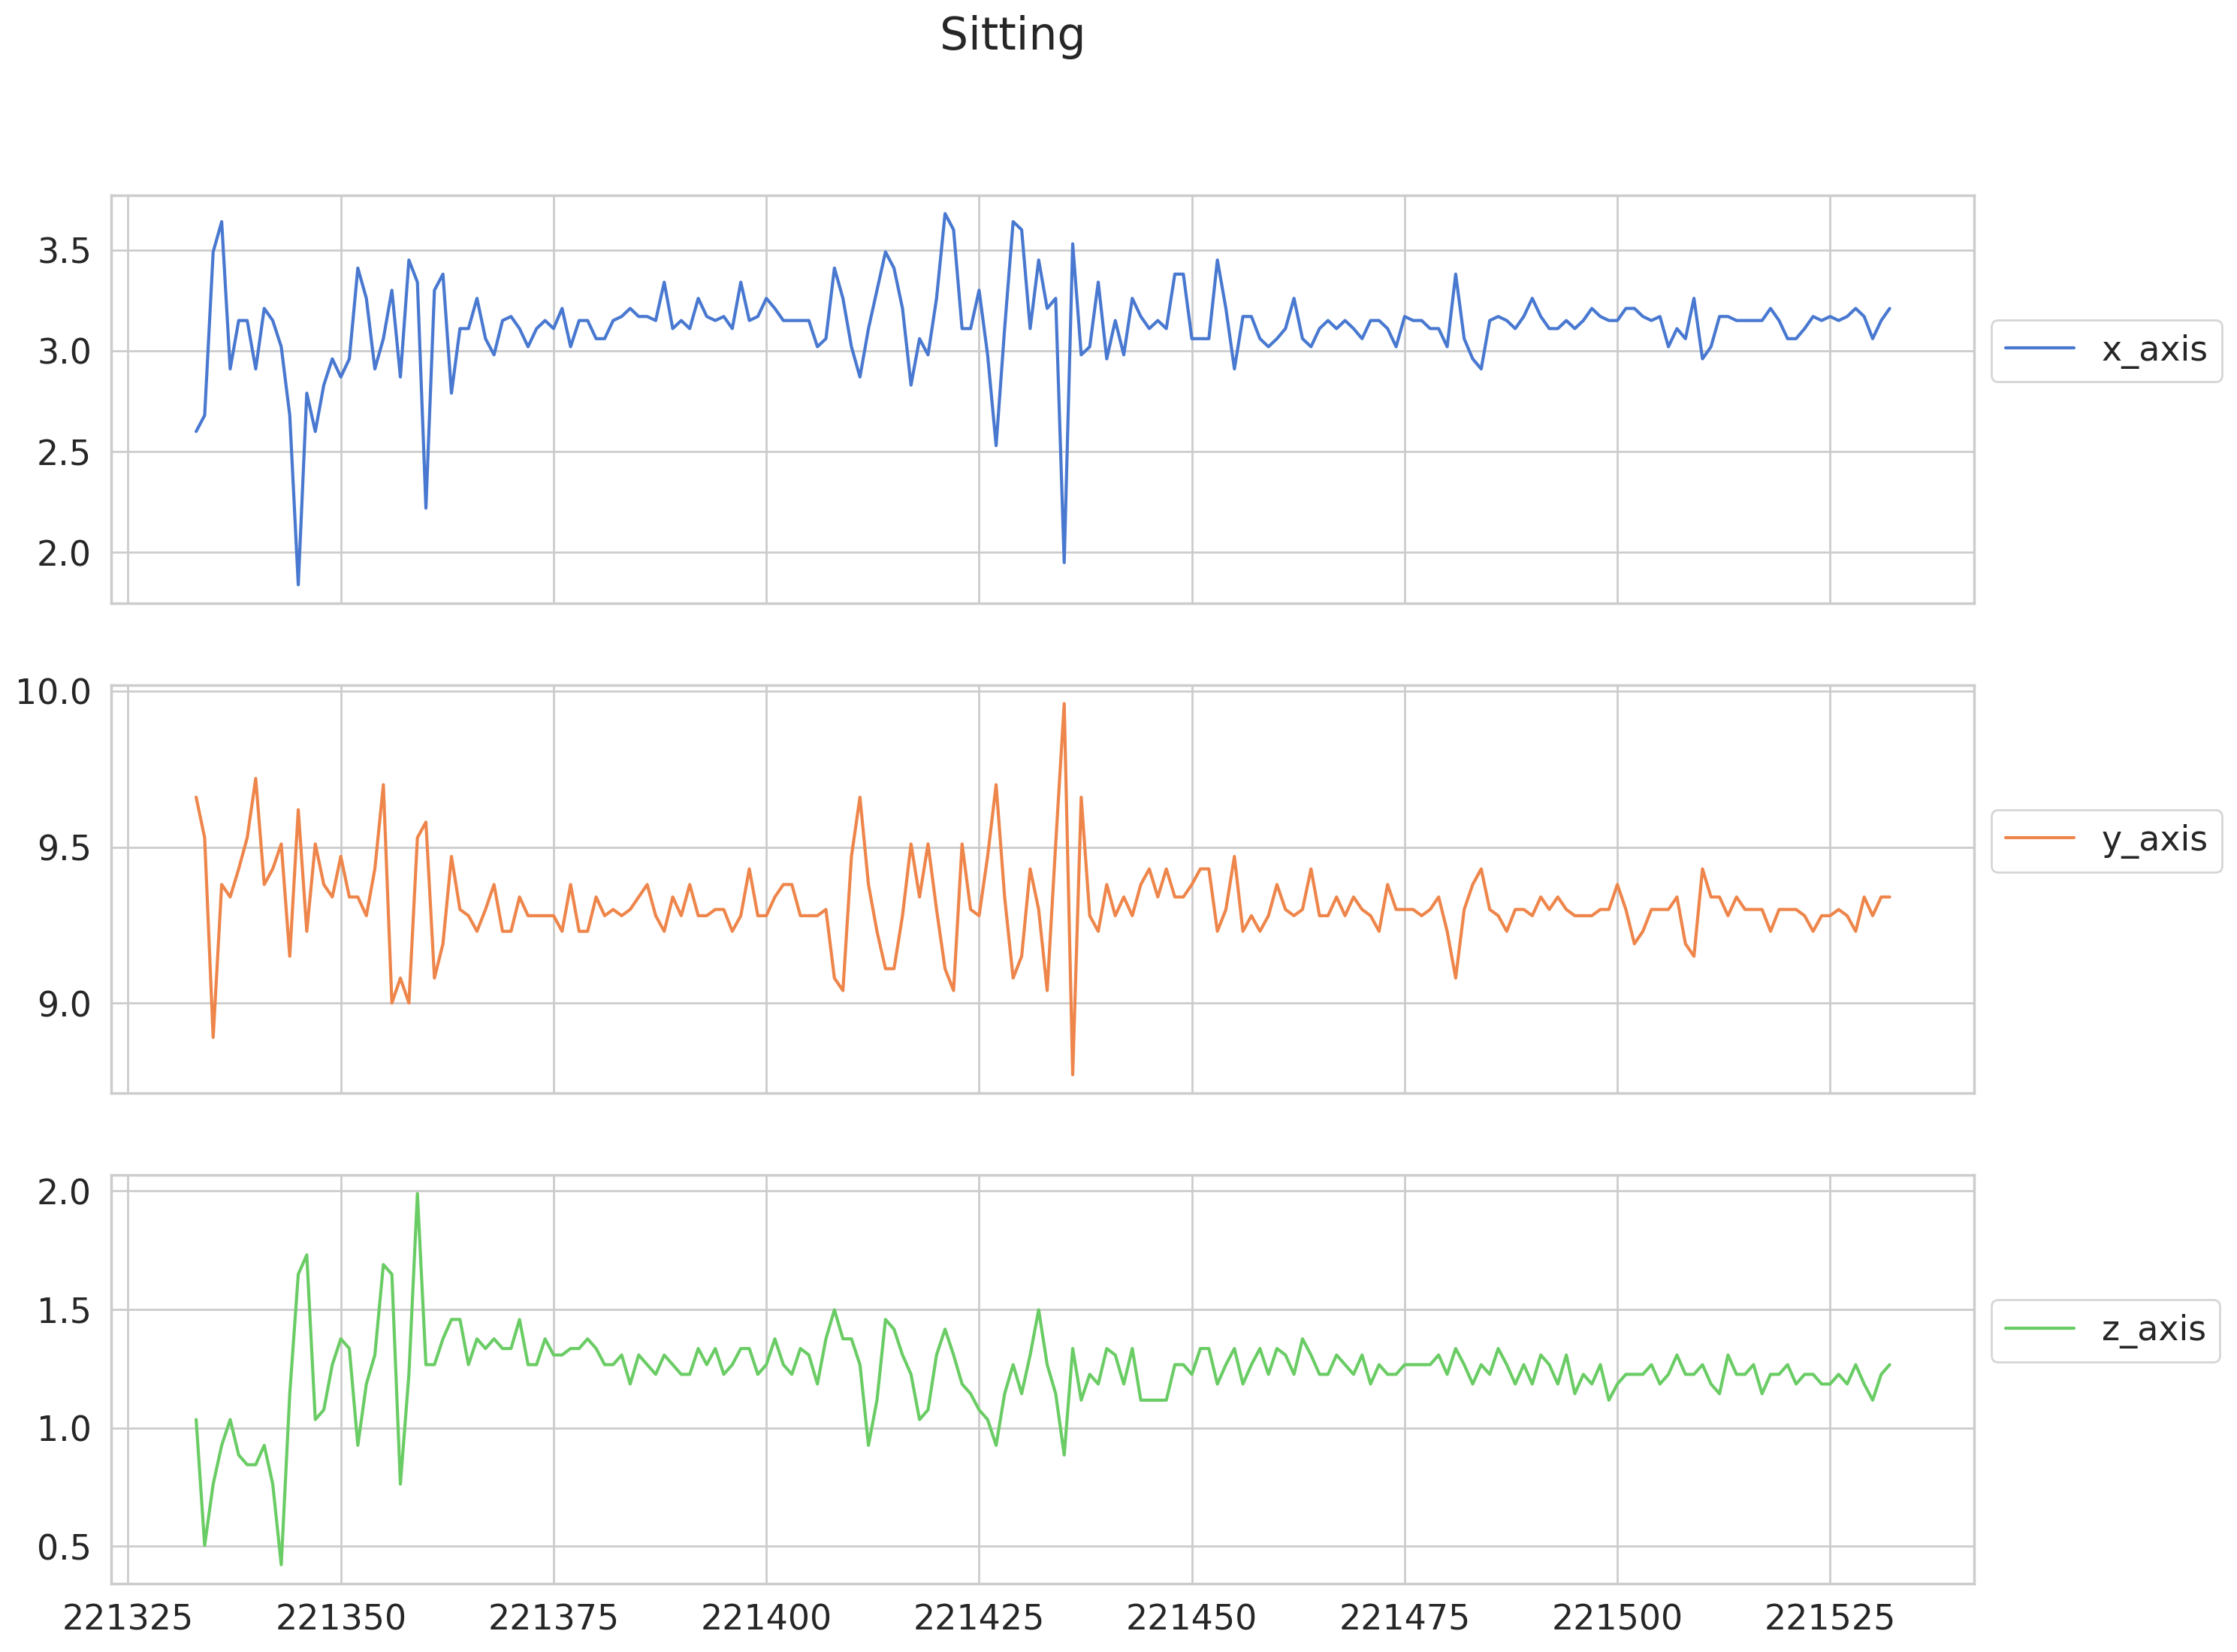

In [8]:

def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)


In [9]:
indexes = df[ (df['activity'] != 'Sitting') & (df['activity'] != 'Standing')].index
df.drop(indexes , inplace=True)


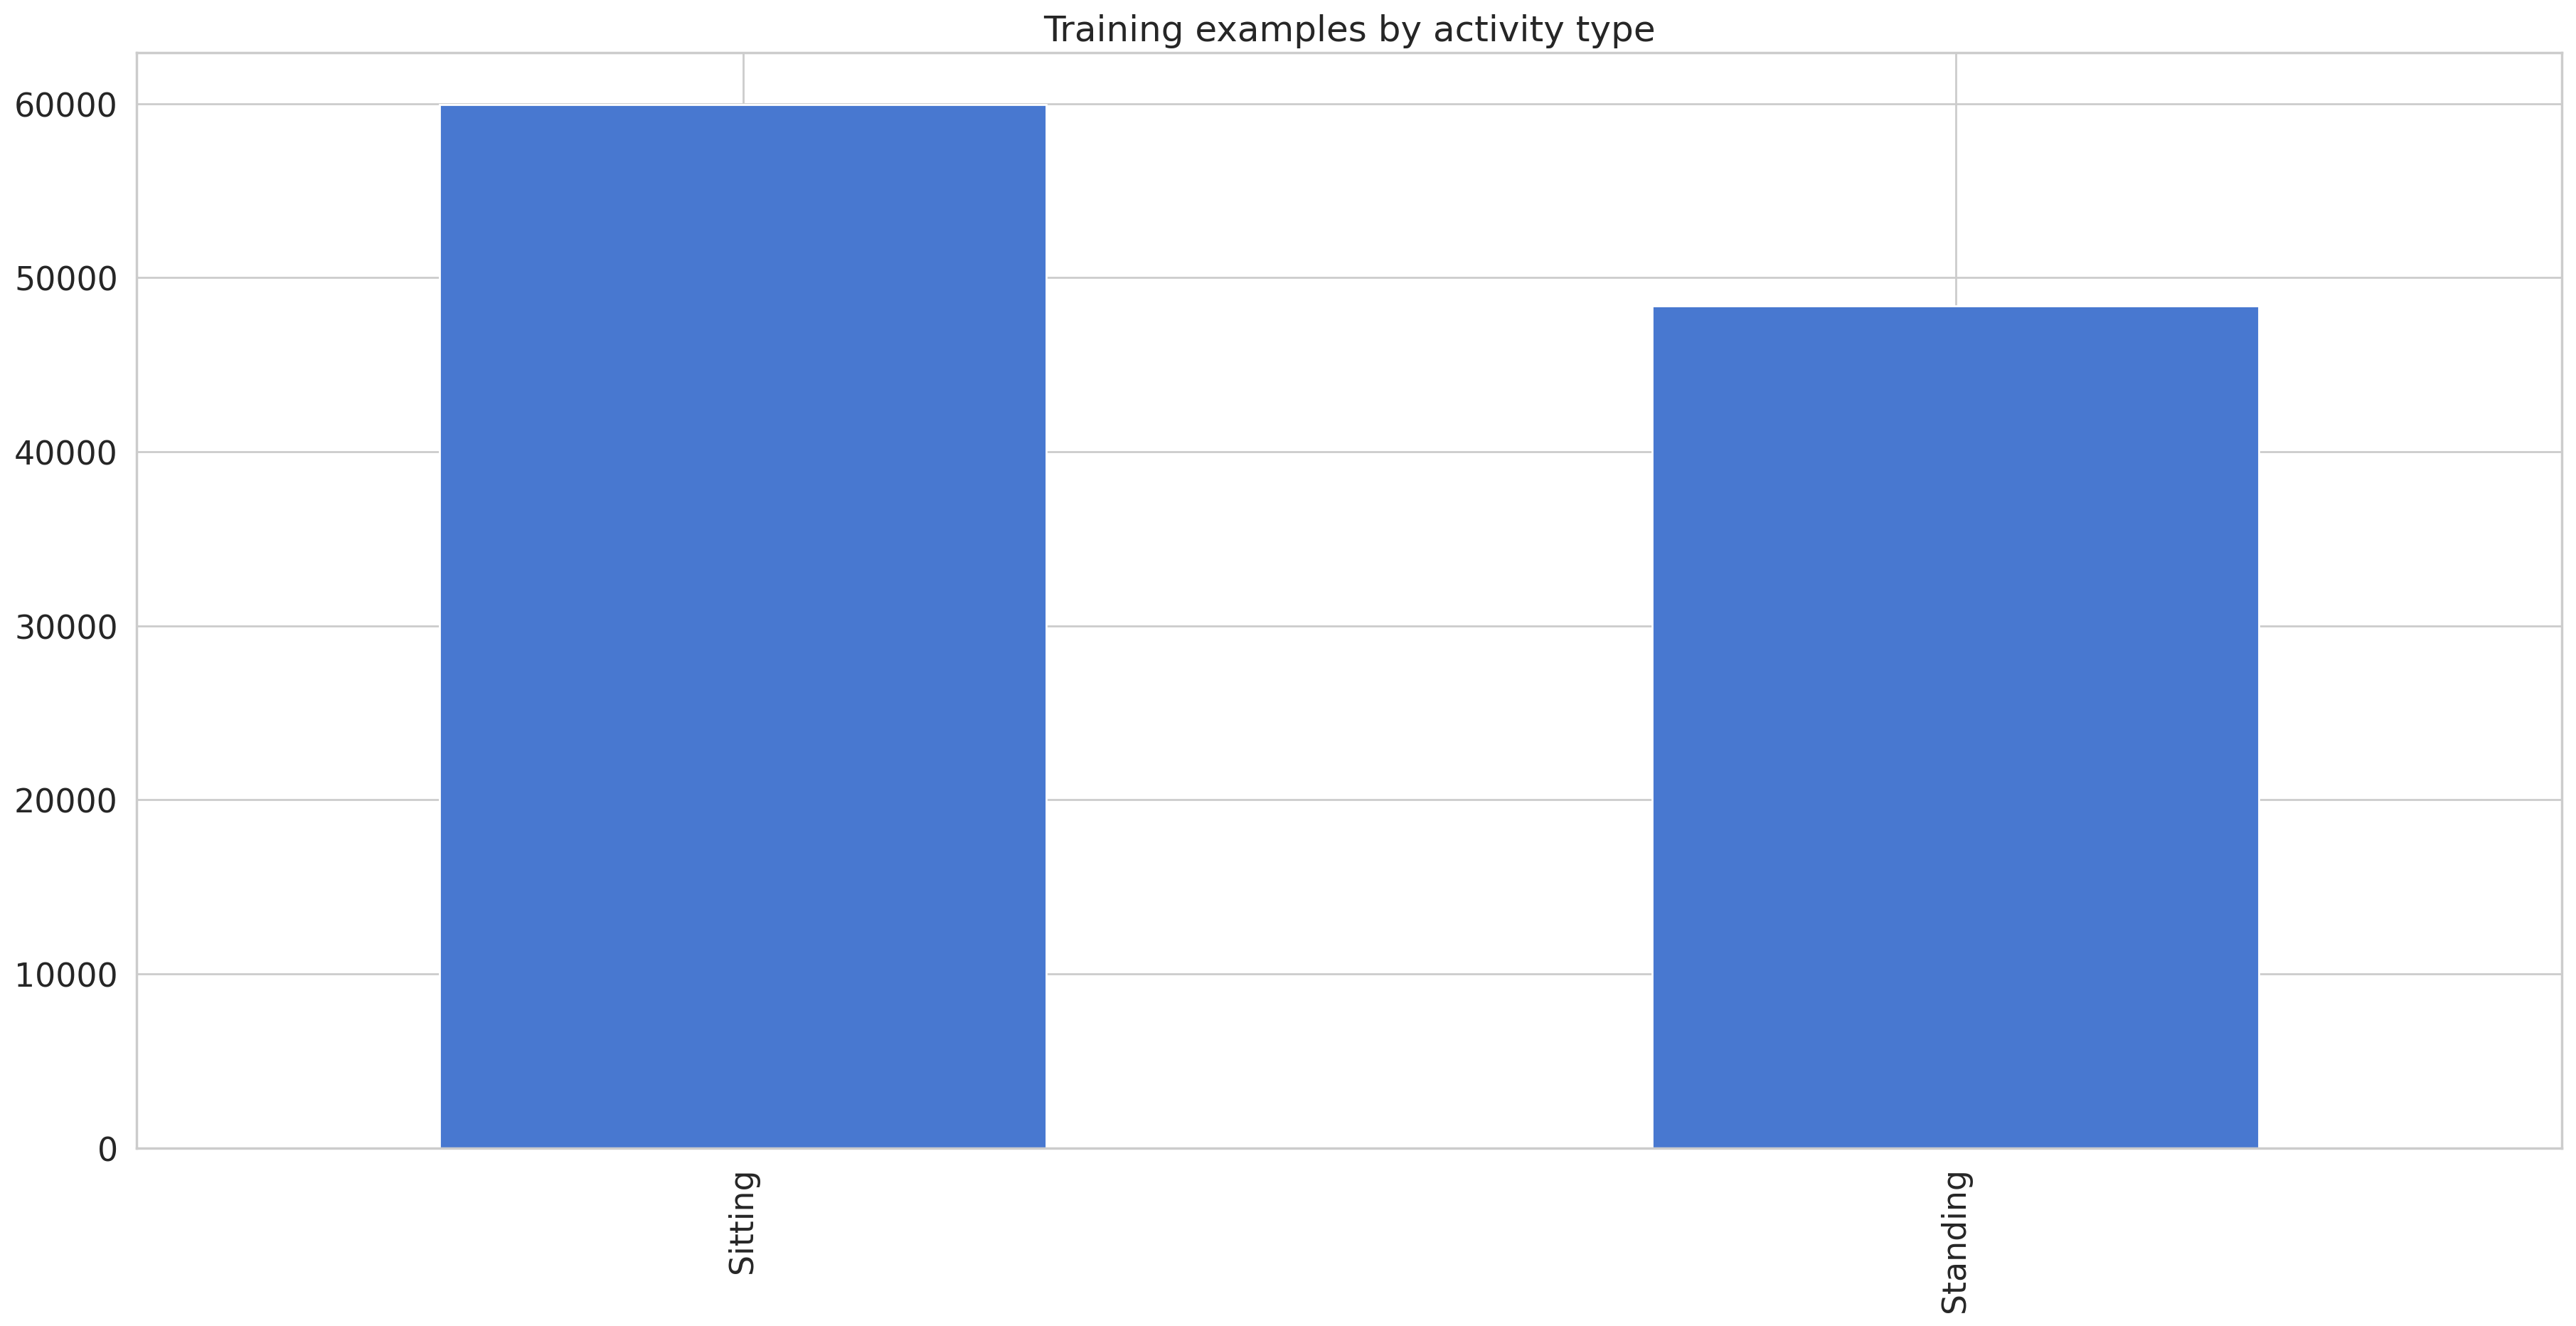

In [10]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

random_seed = 42

n_time_steps = 50

n_features = 3

step = 10

n_classes = 6

n_epochs = 50       

batch_size = 1024   

learning_rate = 0.0025

l2_loss = 0.0015


In [11]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()

scaler = scaler.fit(df[scale_columns])

df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
221333,27,Sitting,12363992261000,0.490260,0.617689,-0.241746,4
221334,27,Sitting,12364042279000,0.503247,0.599144,-0.311732,4
221335,27,Sitting,12364092267000,0.634740,0.507846,-0.277636,4
221336,27,Sitting,12364142316000,0.659091,0.577746,-0.256102,4
221337,27,Sitting,12364192273000,0.540584,0.572040,-0.241746,4
...,...,...,...,...,...,...,...
1098200,19,Sitting,131623331483000,1.529221,-0.984308,-0.155468,4
1098201,19,Sitting,131623371431000,1.535714,-0.968616,-0.150198,4
1098202,19,Sitting,131623411592000,1.542208,-0.957204,-0.155468,4
1098203,19,Sitting,131623491487000,1.529221,-0.968616,-0.150198,4


In [12]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 50
STEP = 10

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6930, 50, 3) (6930, 1)
(2166, 50, 3) (2166, 1)


In [13]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(6930, 50, 3) (6930, 2) (2166, 50, 3) (2166, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:

batch_size = 1024
learning_rate = 0.0025
l2_loss = 0.0015
n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(50, 3, 2)

# LSTM1


In [ ]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 128)               67584     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 2)                 130       
                                                                 
Total params: 75970 (296.76 KB)
Trainable params: 75970 (296.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# validation_split = 0.1
batch_size = 1024

train_epochs = 10

history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
7/7 [==============================] - 6s 148ms/step - loss: 0.5341 - accuracy: 0.8257 - val_loss: 0.3087 - val_accuracy: 0.9267
Epoch 2/10
7/7 [==============================] - 0s 28ms/step - loss: 0.2273 - accuracy: 0.9356 - val_loss: 0.1697 - val_accuracy: 0.9342
Epoch 3/10
7/7 [==============================] - 0s 24ms/step - loss: 0.1594 - accuracy: 0.9475 - val_loss: 0.1353 - val_accuracy: 0.9538
Epoch 4/10
7/7 [==============================] - 0s 23ms/step - loss: 0.1267 - accuracy: 0.9528 - val_loss: 0.1363 - val_accuracy: 0.9579
Epoch 5/10
7/7 [==============================] - 0s 29ms/step - loss: 0.1191 - accuracy: 0.9553 - val_loss: 0.1272 - val_accuracy: 0.9567
Epoch 6/10
7/7 [==============================] - 0s 32ms/step - loss: 0.1109 - accuracy: 0.9527 - val_loss: 0.1202 - val_accuracy: 0.9527
Epoch 7/10
7/7 [==============================] - 0s 26ms/step - loss: 0.1041 - accuracy: 0.9511 - val_loss: 0.1216 - val_accuracy: 0.9573
Epoch 8/10
7/7 [==========

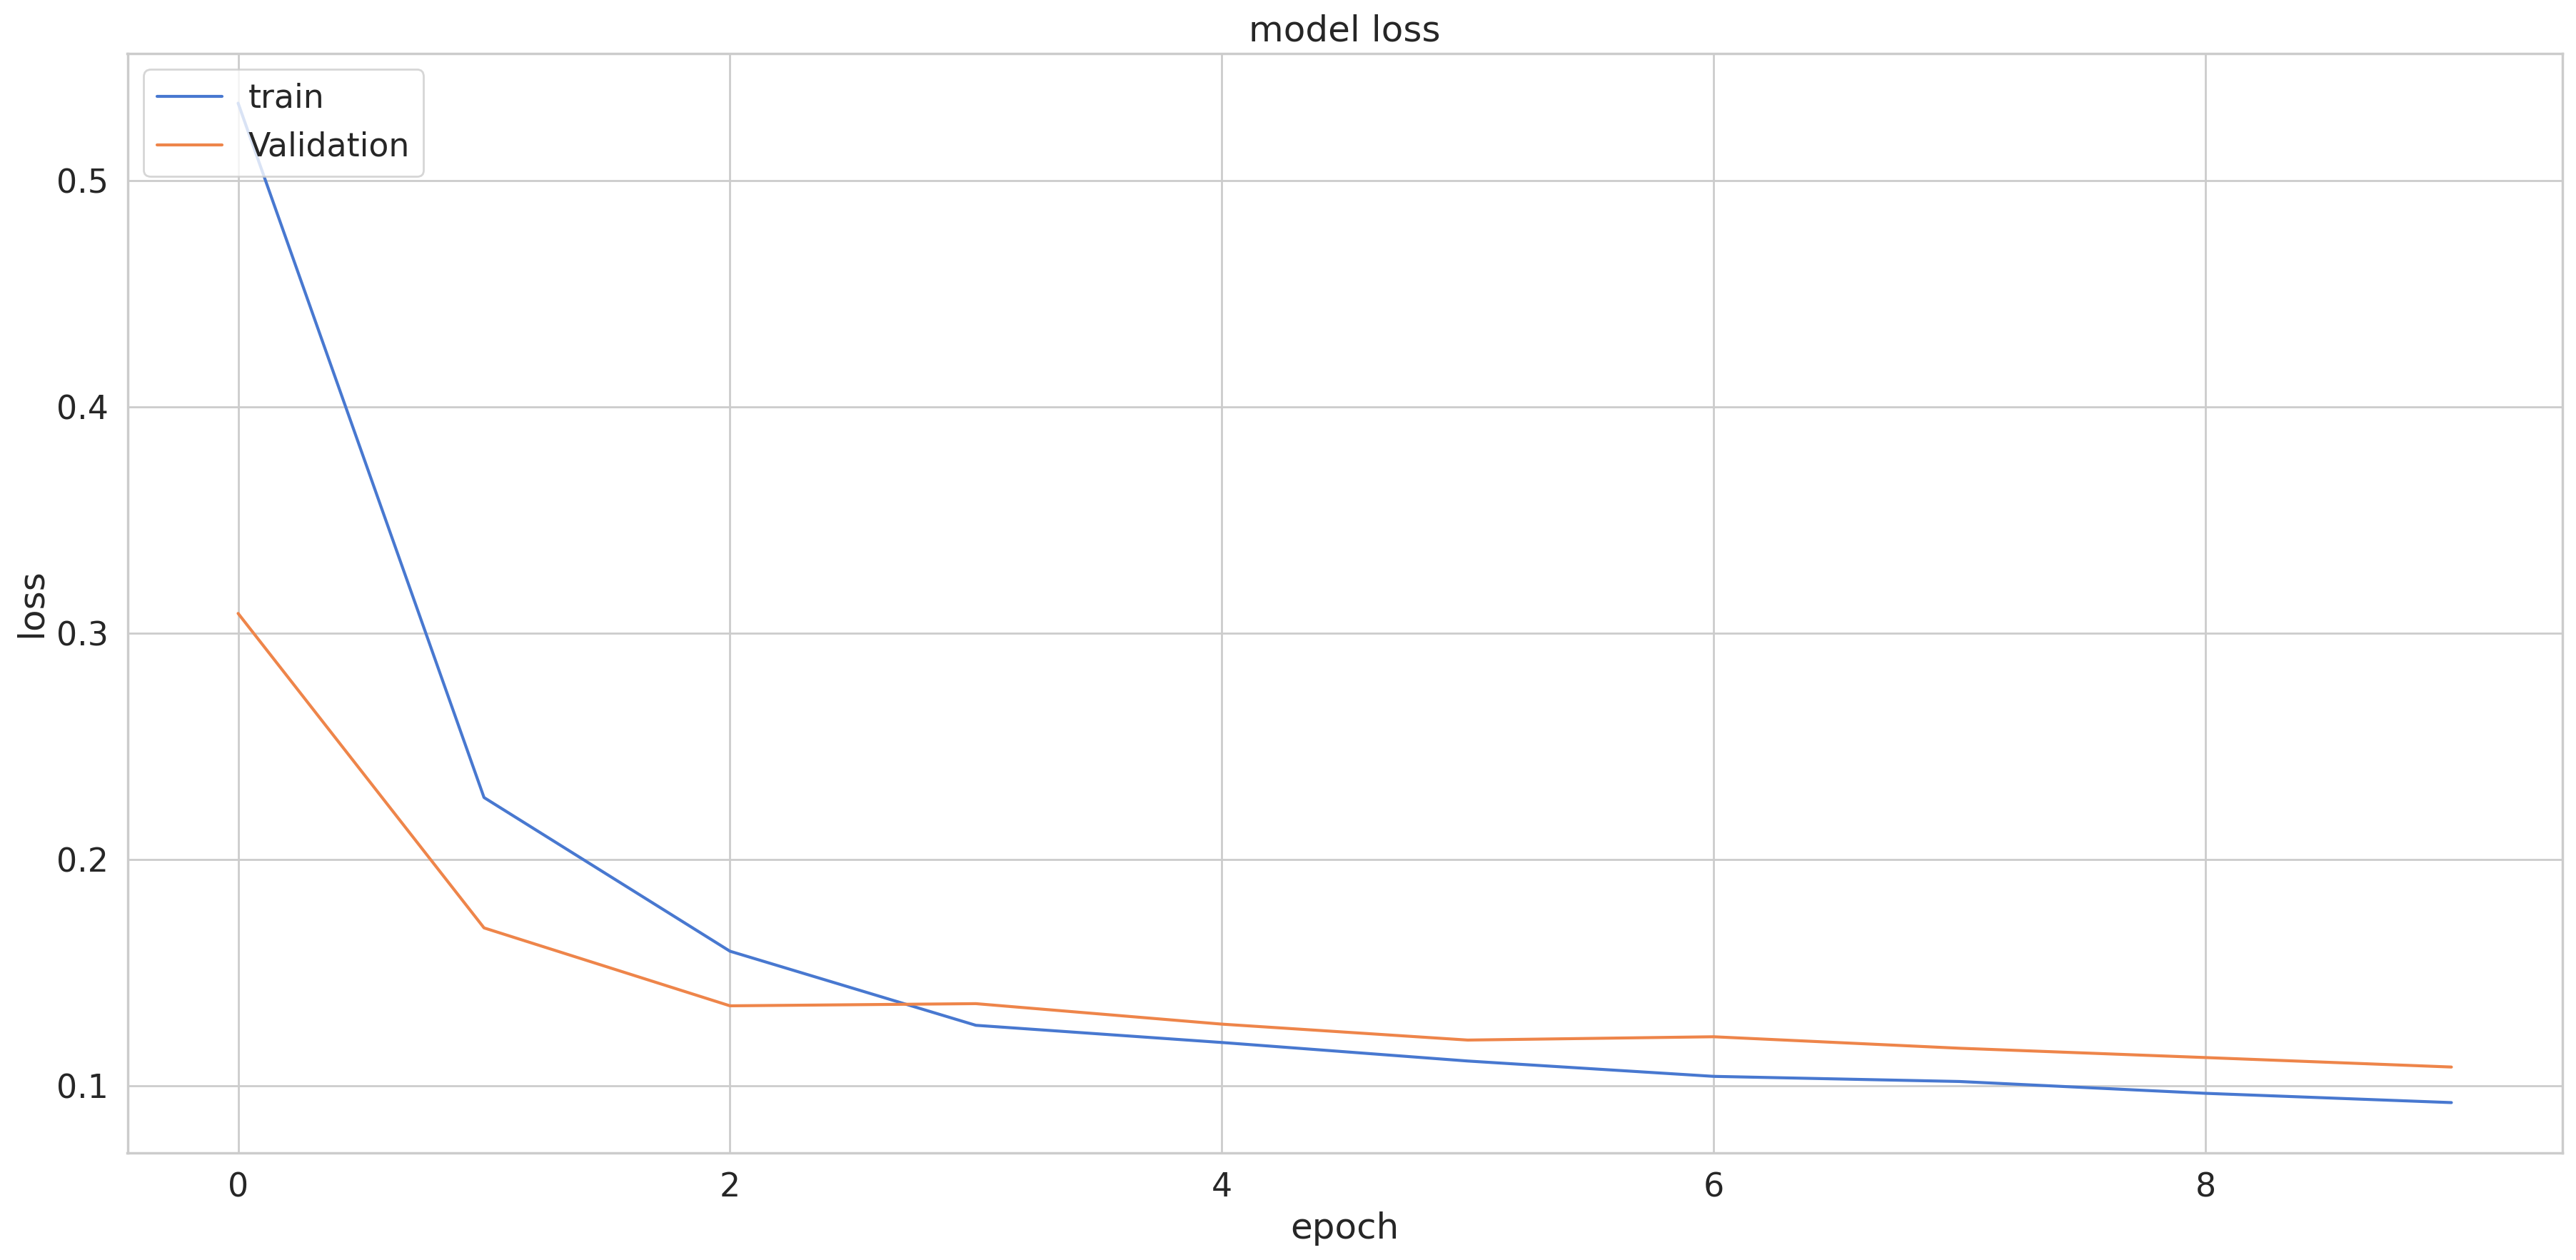

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

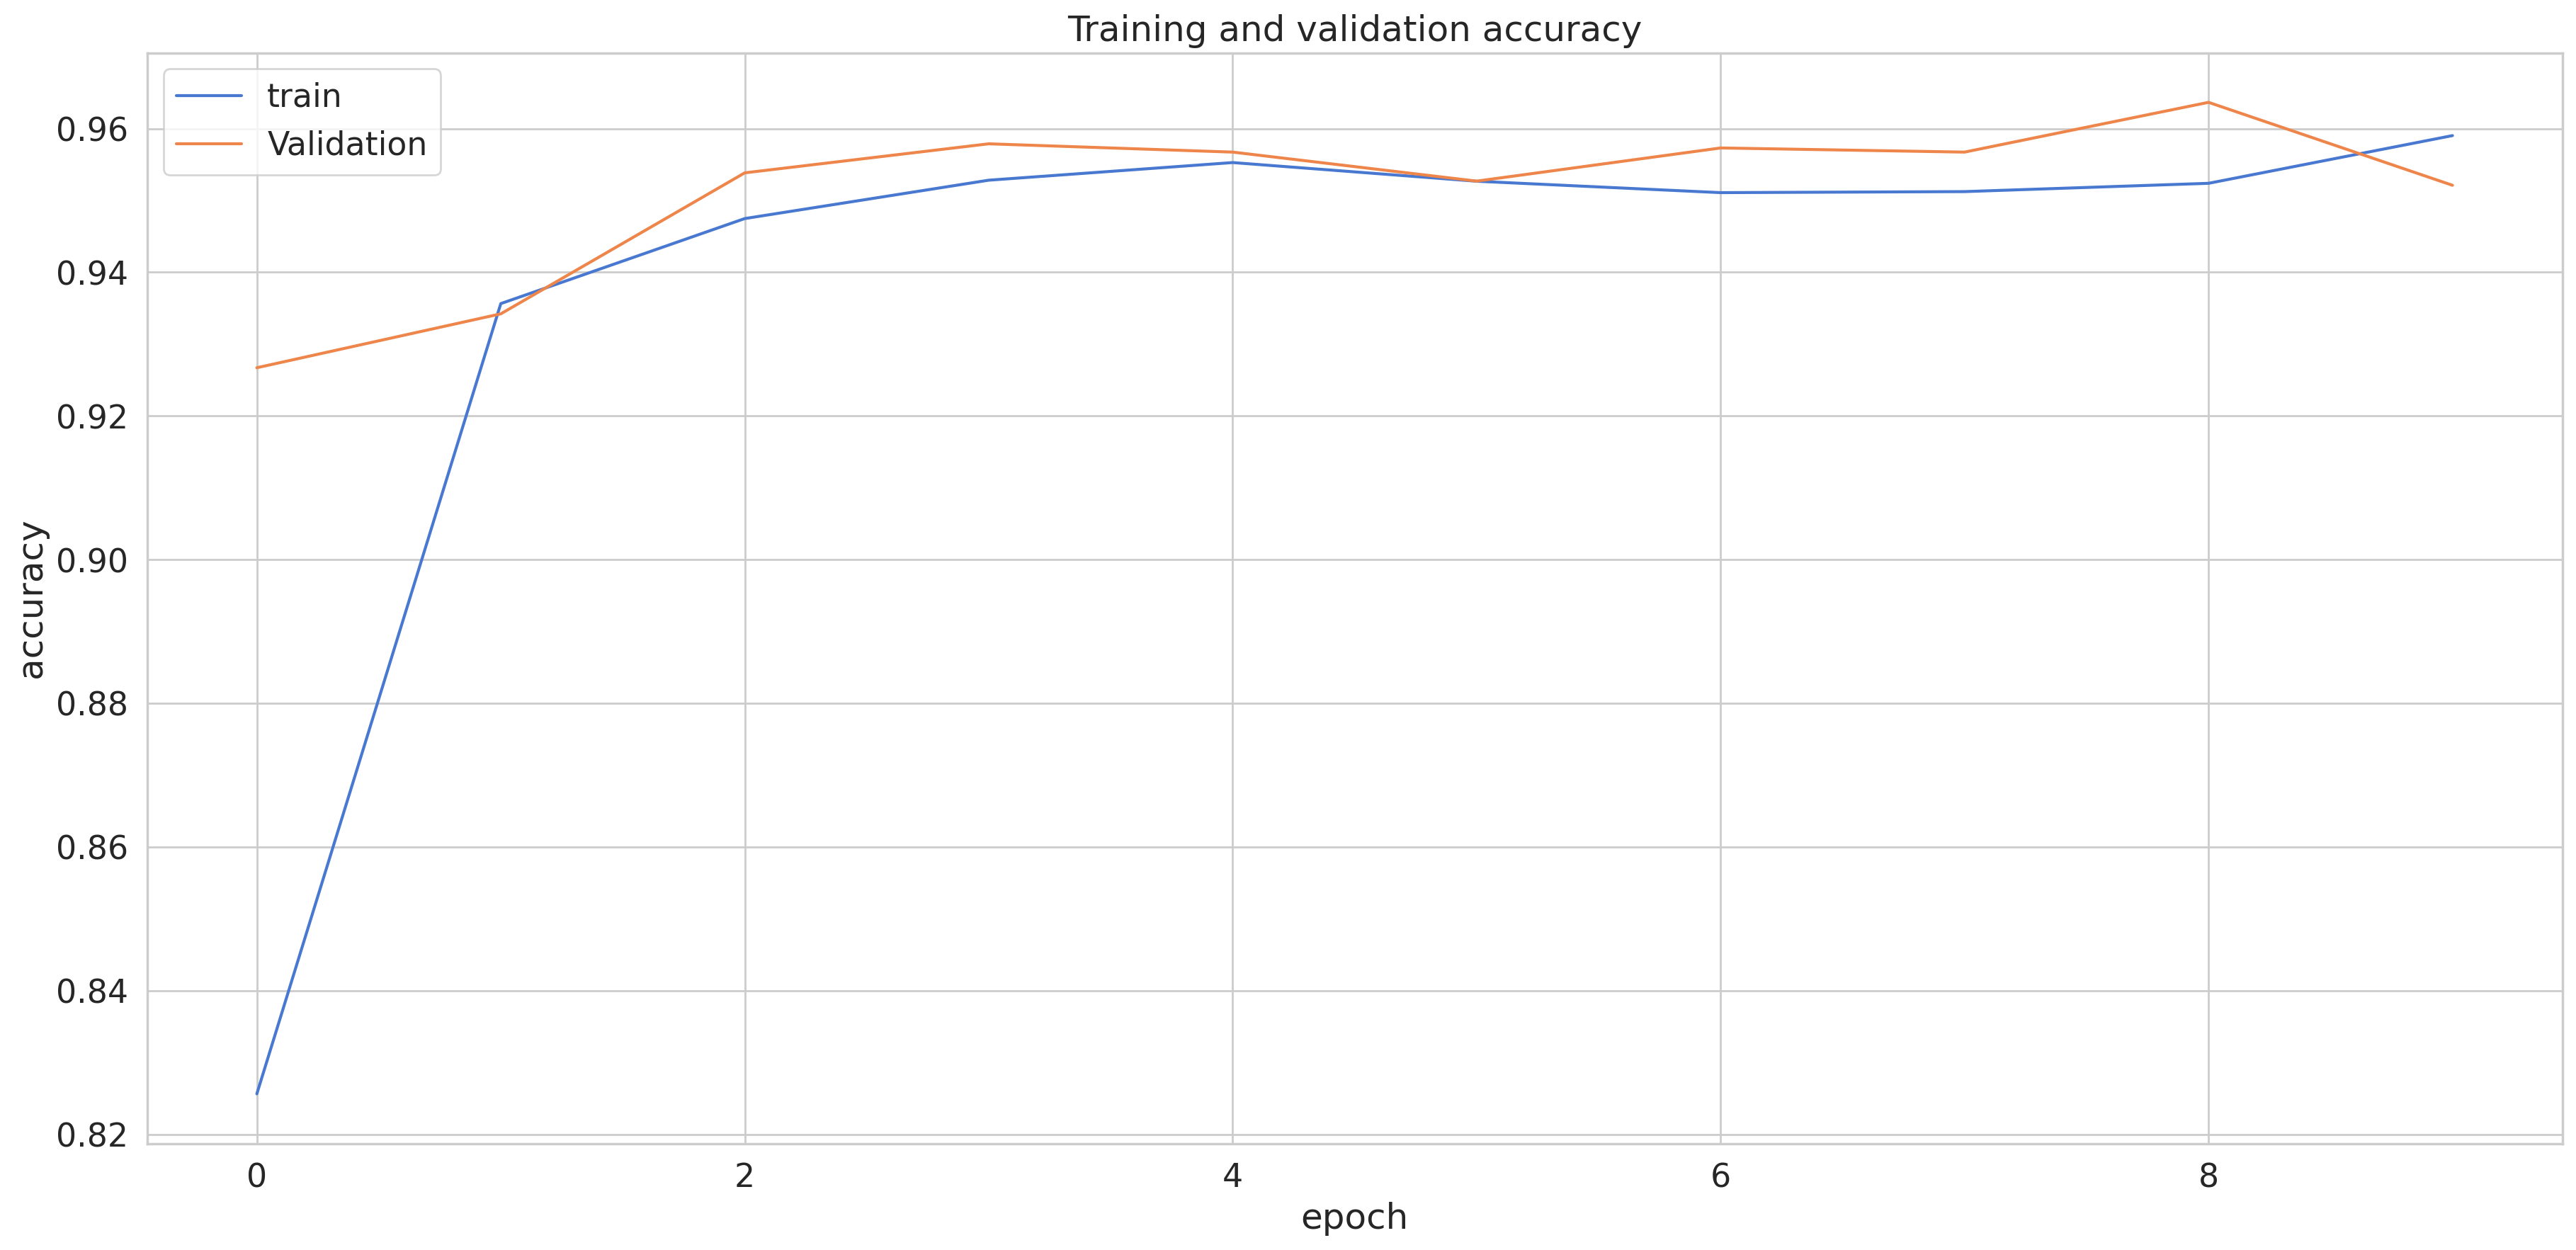

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

68/68 [==============================] - 1s 3ms/step
f1_score =  0.9608587655849141
0.9607571560480148
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1199
           1       0.92      1.00      0.96       967

    accuracy                           0.96      2166
   macro avg       0.96      0.96      0.96      2166
weighted avg       0.96      0.96      0.96      2166



<Axes: >

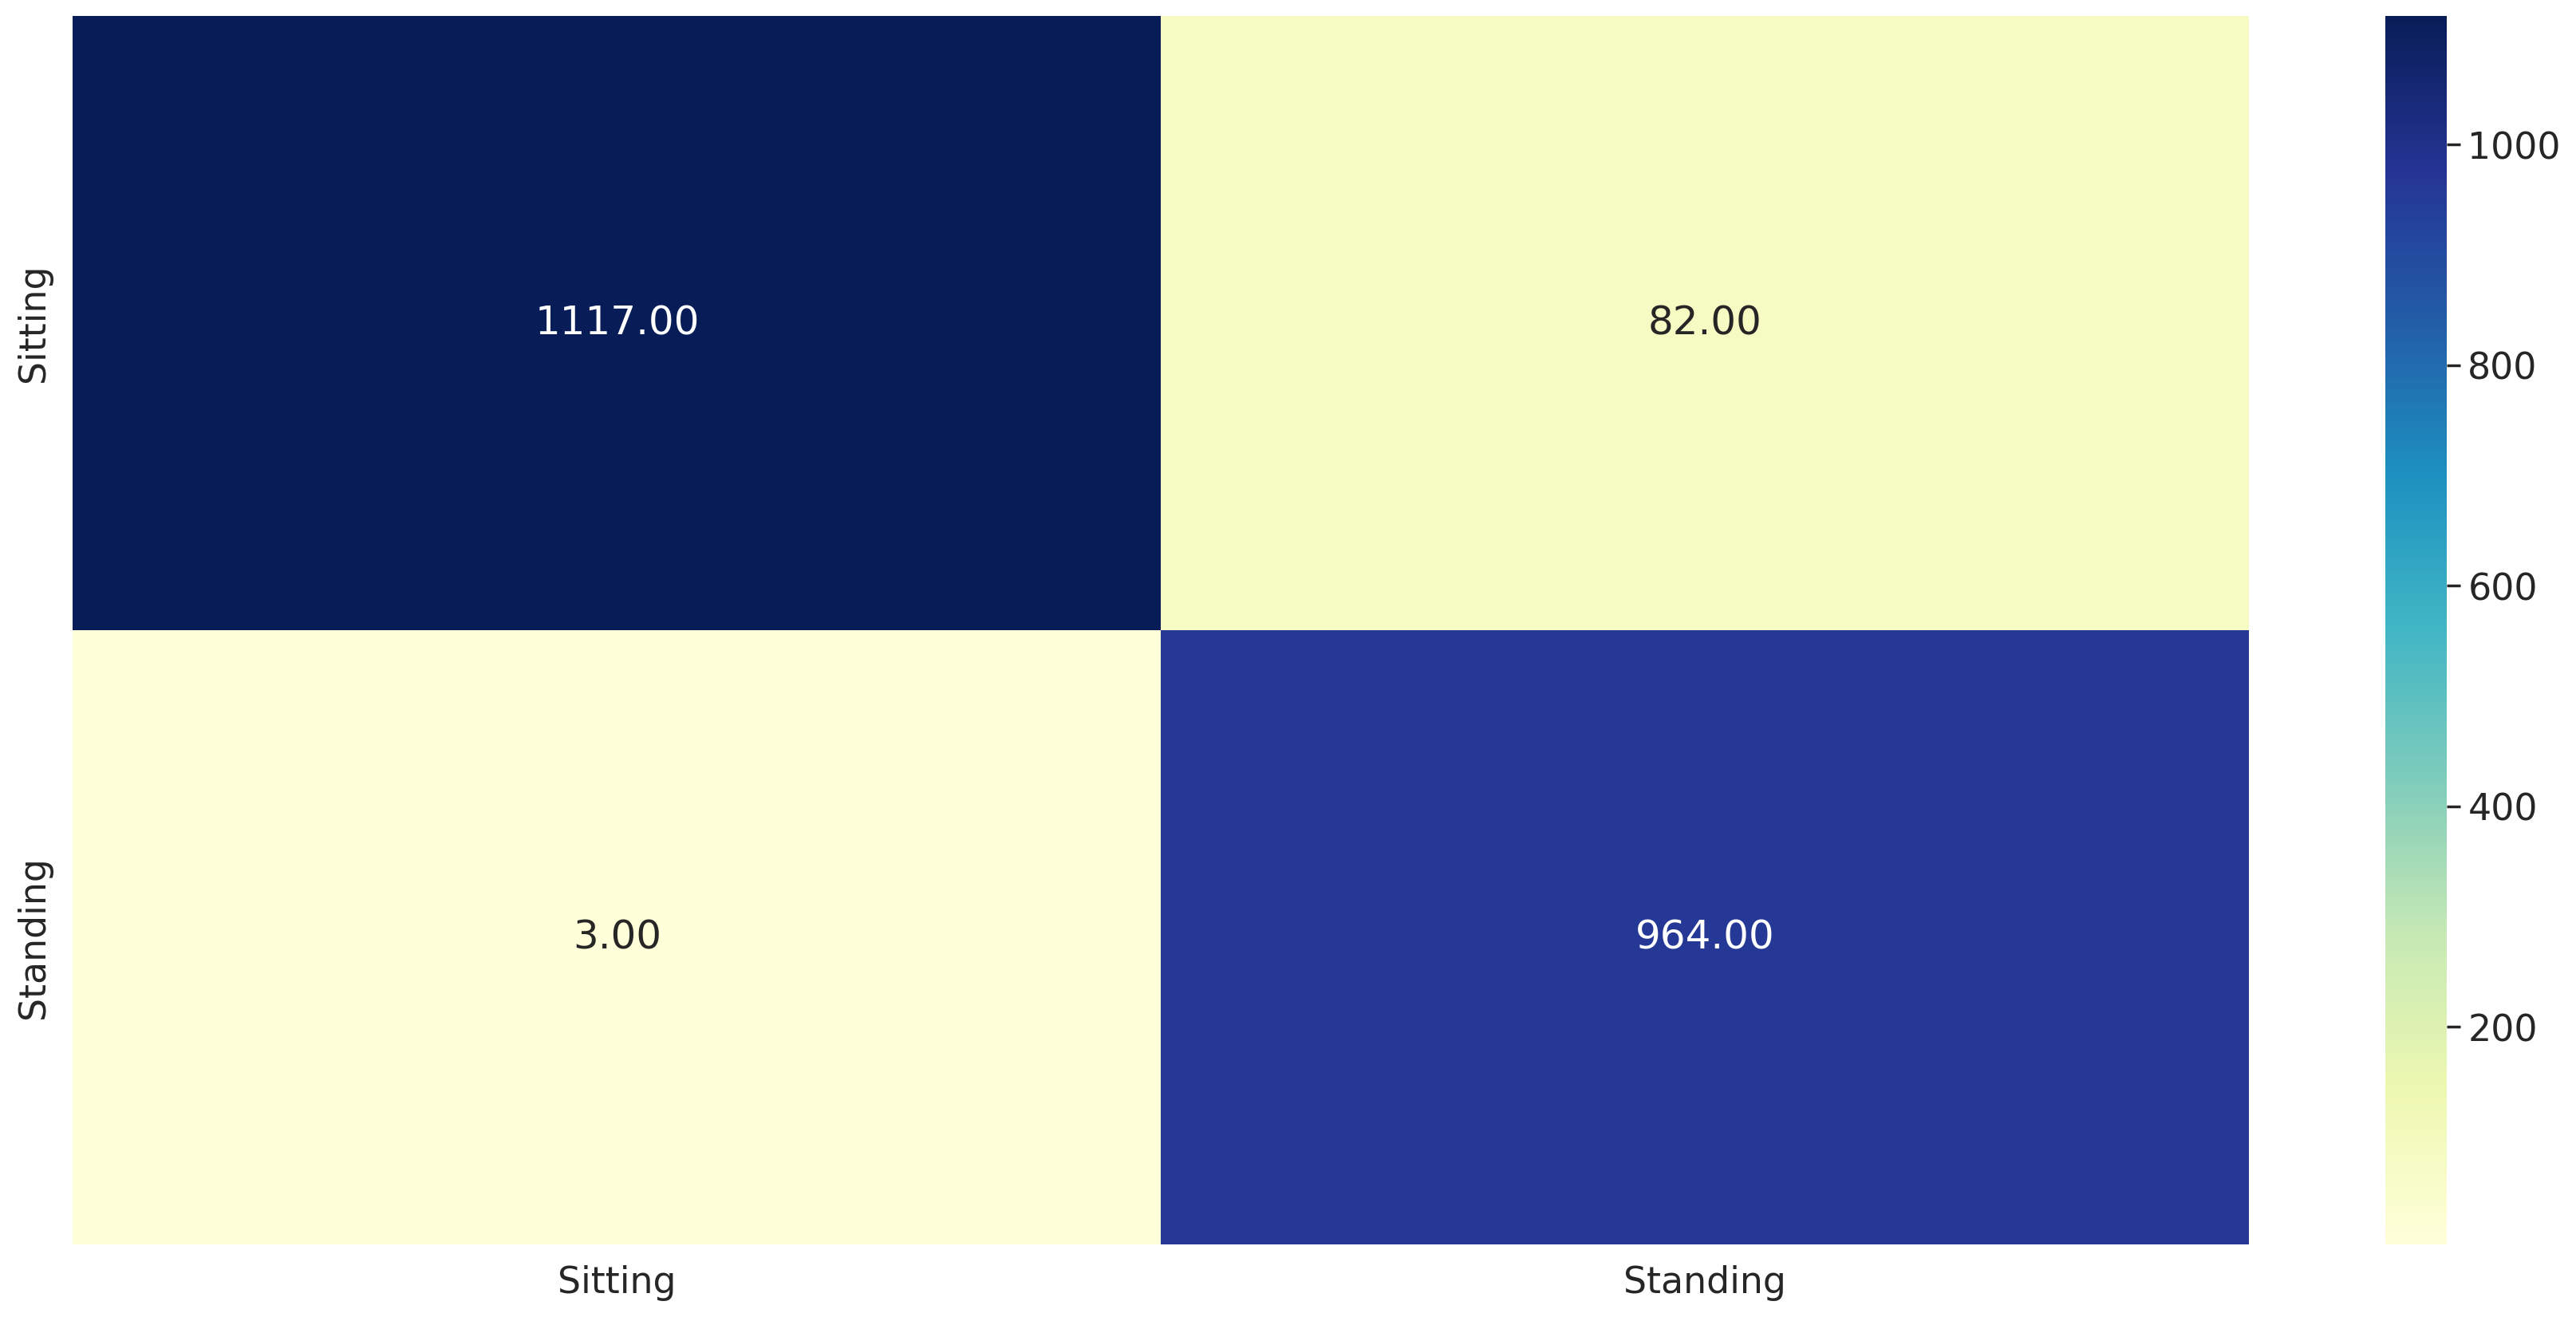

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = [ 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM2

In [ ]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 50, 128)           67584     
                                                                 
 dropout_22 (Dropout)        (None, 50, 128)           0         
                                                                 
 lstm_23 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_23 (Dropout)        (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 2)                 130       
                                                                 
Total params: 207554 (810.76 KB)
Trainable params: 207

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
55/55 [==============================] - 7s 28ms/step - loss: 0.1644 - accuracy: 0.9444 - val_loss: 0.1201 - val_accuracy: 0.9521
Epoch 2/10
55/55 [==============================] - 1s 11ms/step - loss: 0.0940 - accuracy: 0.9609 - val_loss: 0.1100 - val_accuracy: 0.9677
Epoch 3/10
55/55 [==============================] - 1s 11ms/step - loss: 0.0866 - accuracy: 0.9625 - val_loss: 0.0995 - val_accuracy: 0.9671
Epoch 4/10
55/55 [==============================] - 1s 12ms/step - loss: 0.1016 - accuracy: 0.9469 - val_loss: 0.1193 - val_accuracy: 0.9683
Epoch 5/10
55/55 [==============================] - 1s 12ms/step - loss: 0.0883 - accuracy: 0.9668 - val_loss: 0.1042 - val_accuracy: 0.9648
Epoch 6/10
55/55 [==============================] - 1s 11ms/step - loss: 0.0810 - accuracy: 0.9675 - val_loss: 0.1179 - val_accuracy: 0.9498
Epoch 7/10
55/55 [==============================] - 1s 11ms/step - loss: 0.1012 - accuracy: 0.9661 - val_loss: 0.1471 - val_accuracy: 0.9498
Epoch 8/10
55

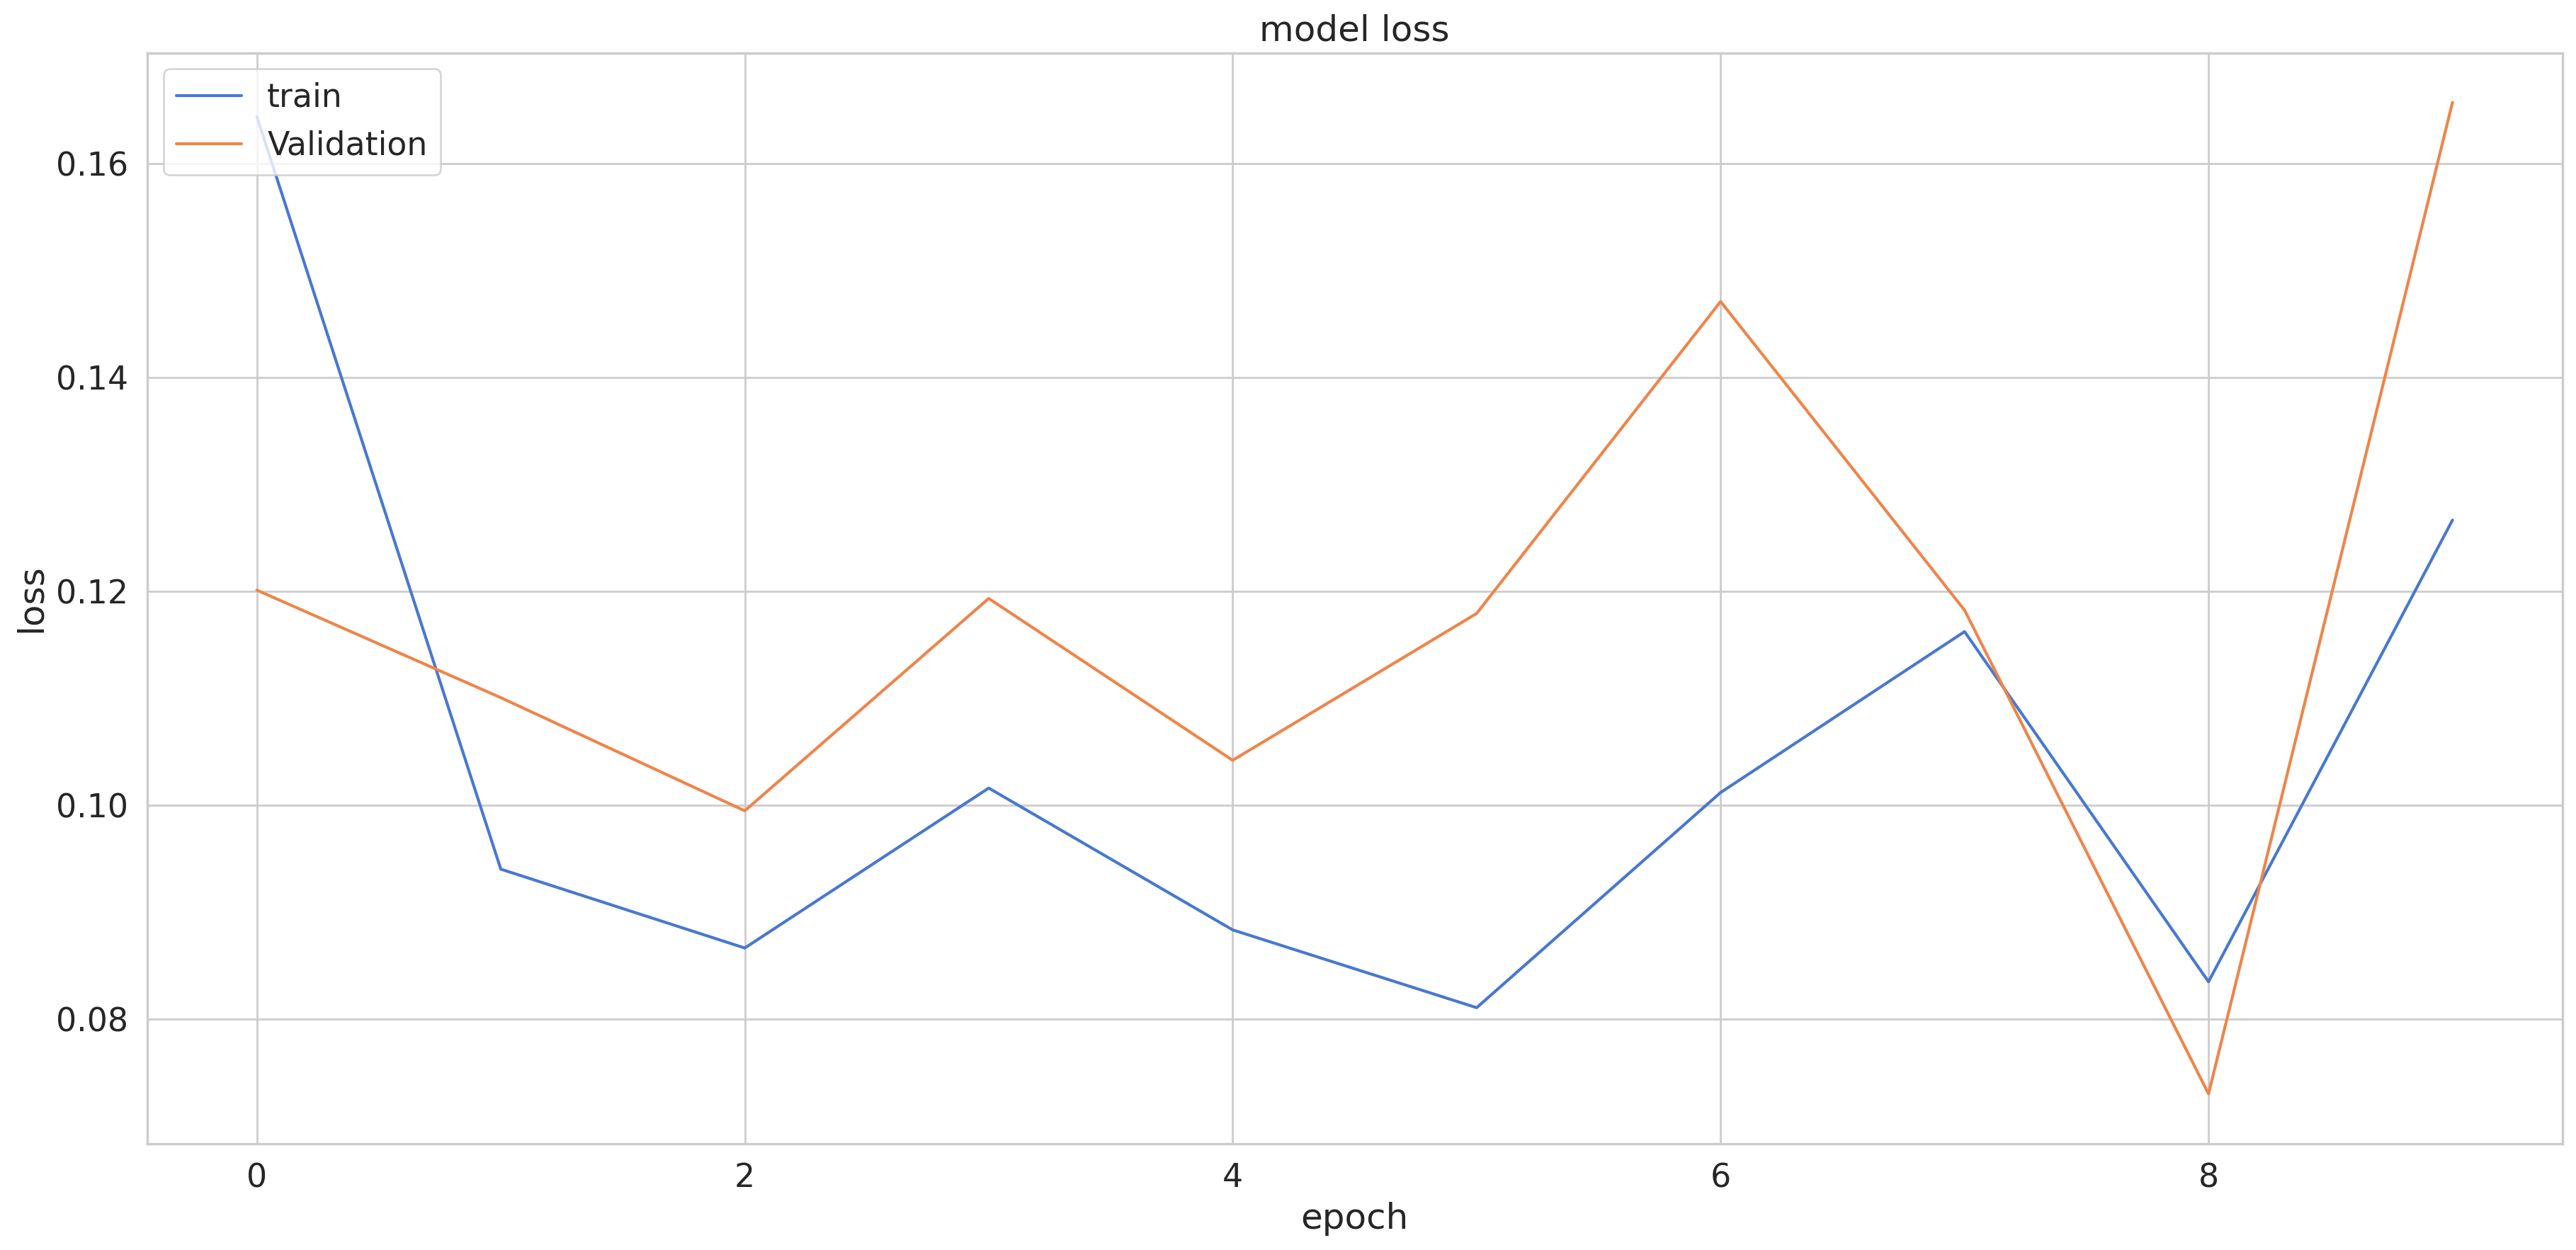

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

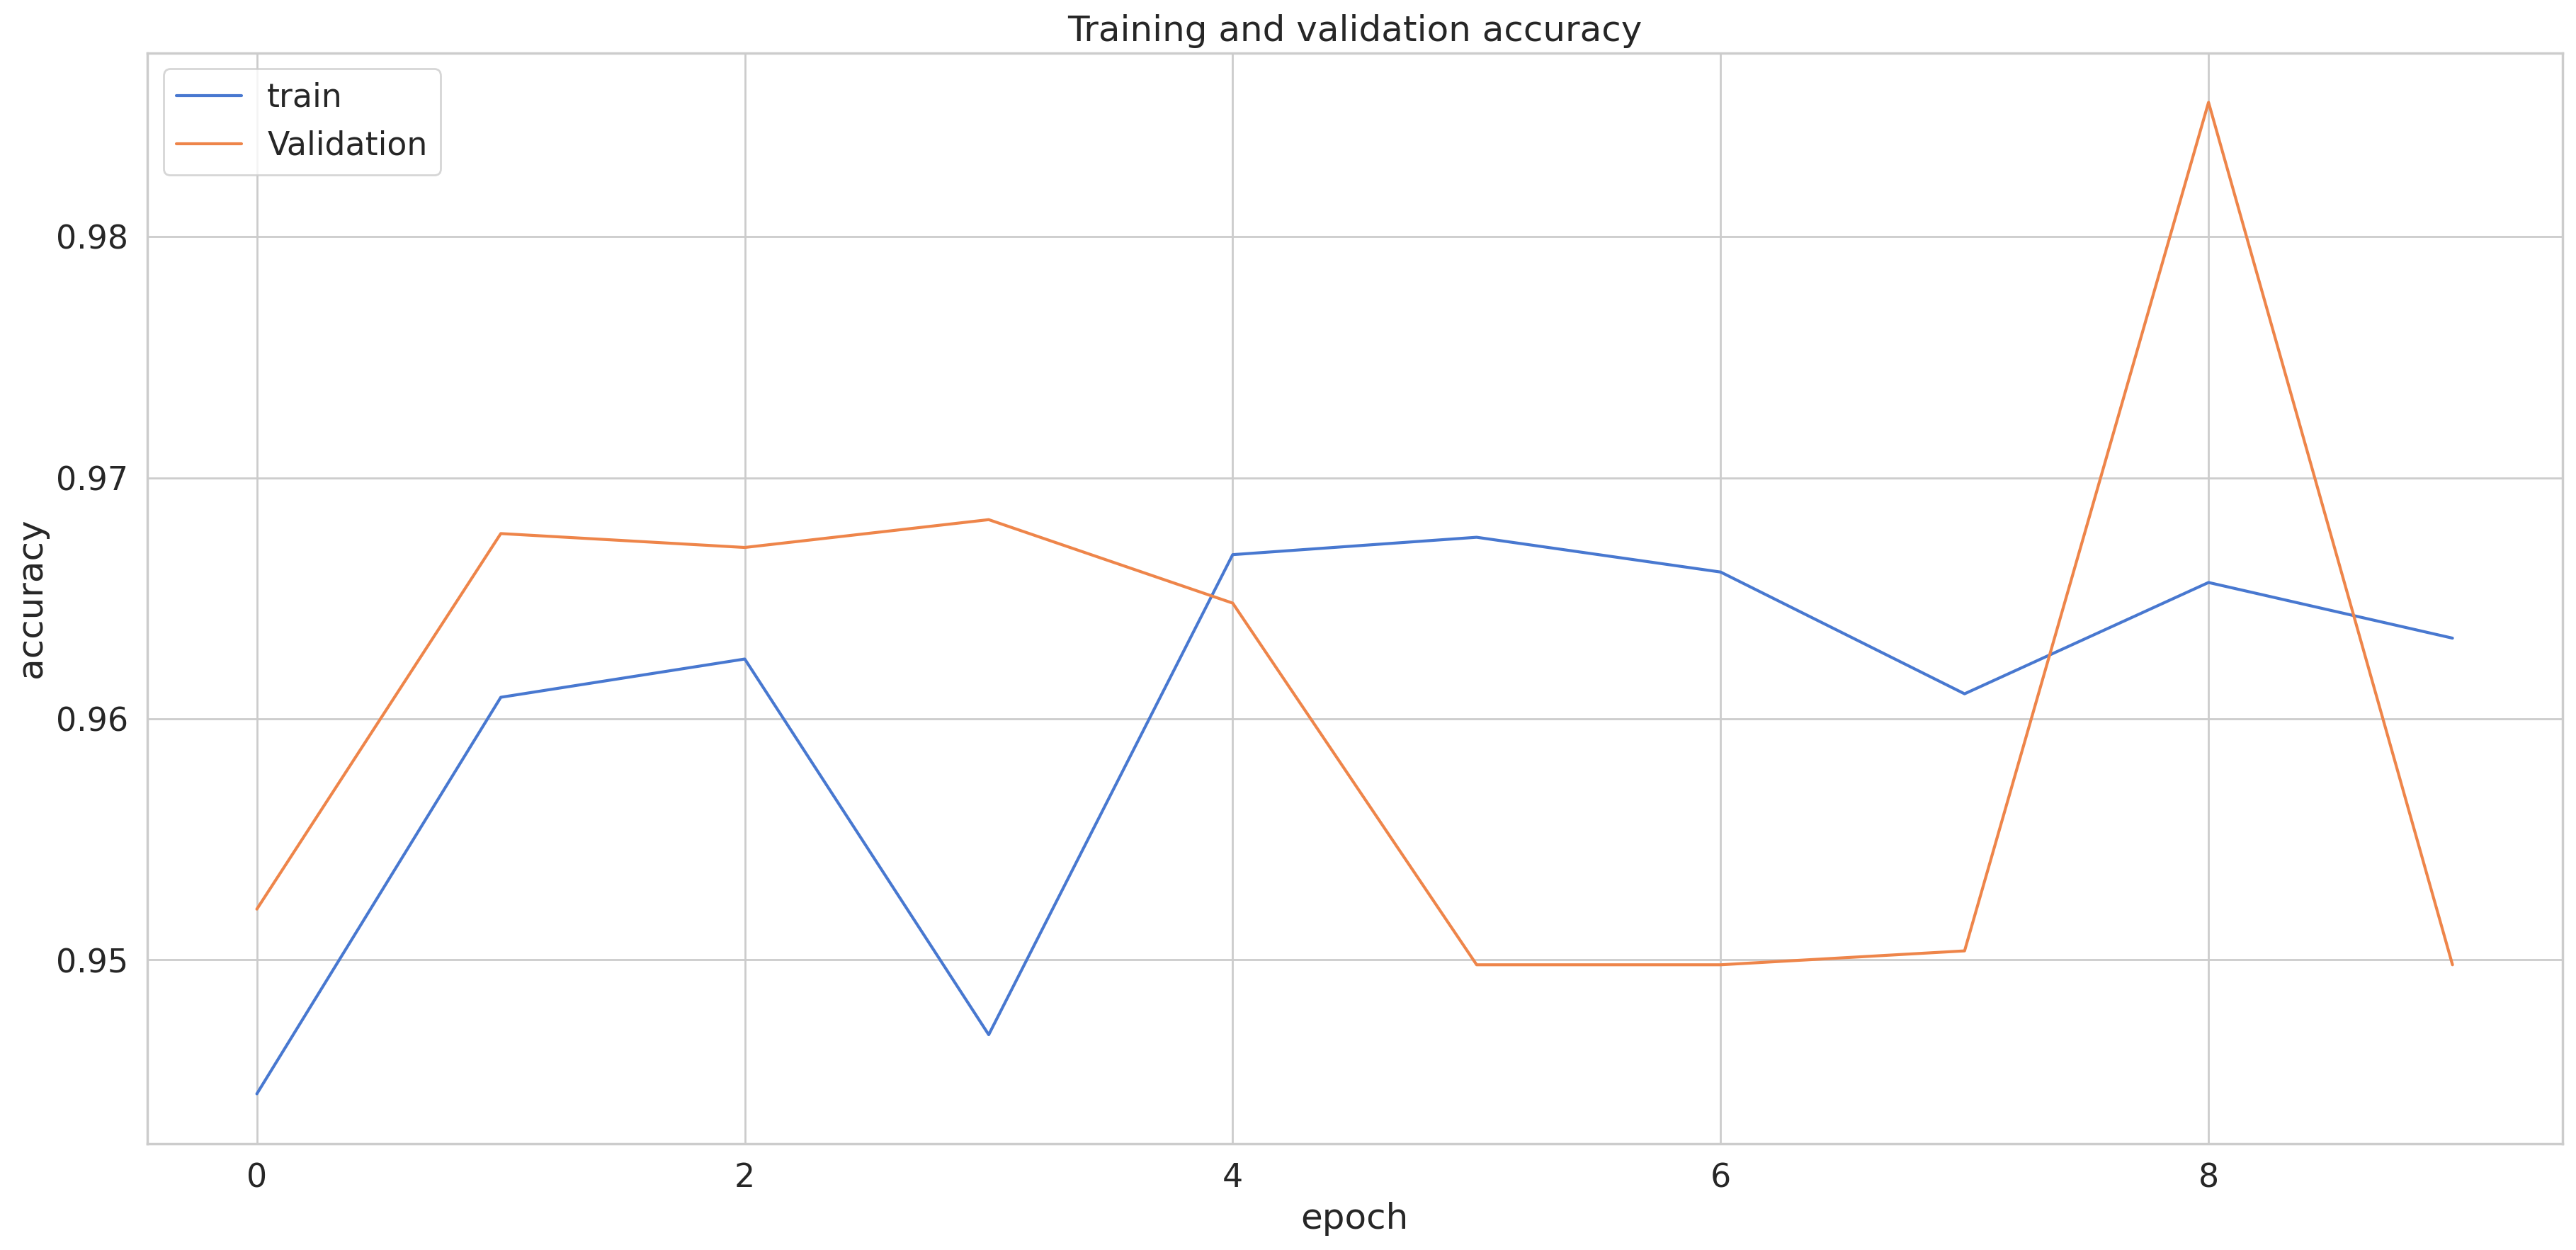

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

68/68 [==============================] - 1s 4ms/step
f1_score =  0.9608610925127202
0.9607571560480148
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1199
           1       0.92      1.00      0.96       967

    accuracy                           0.96      2166
   macro avg       0.96      0.96      0.96      2166
weighted avg       0.96      0.96      0.96      2166



<Axes: >

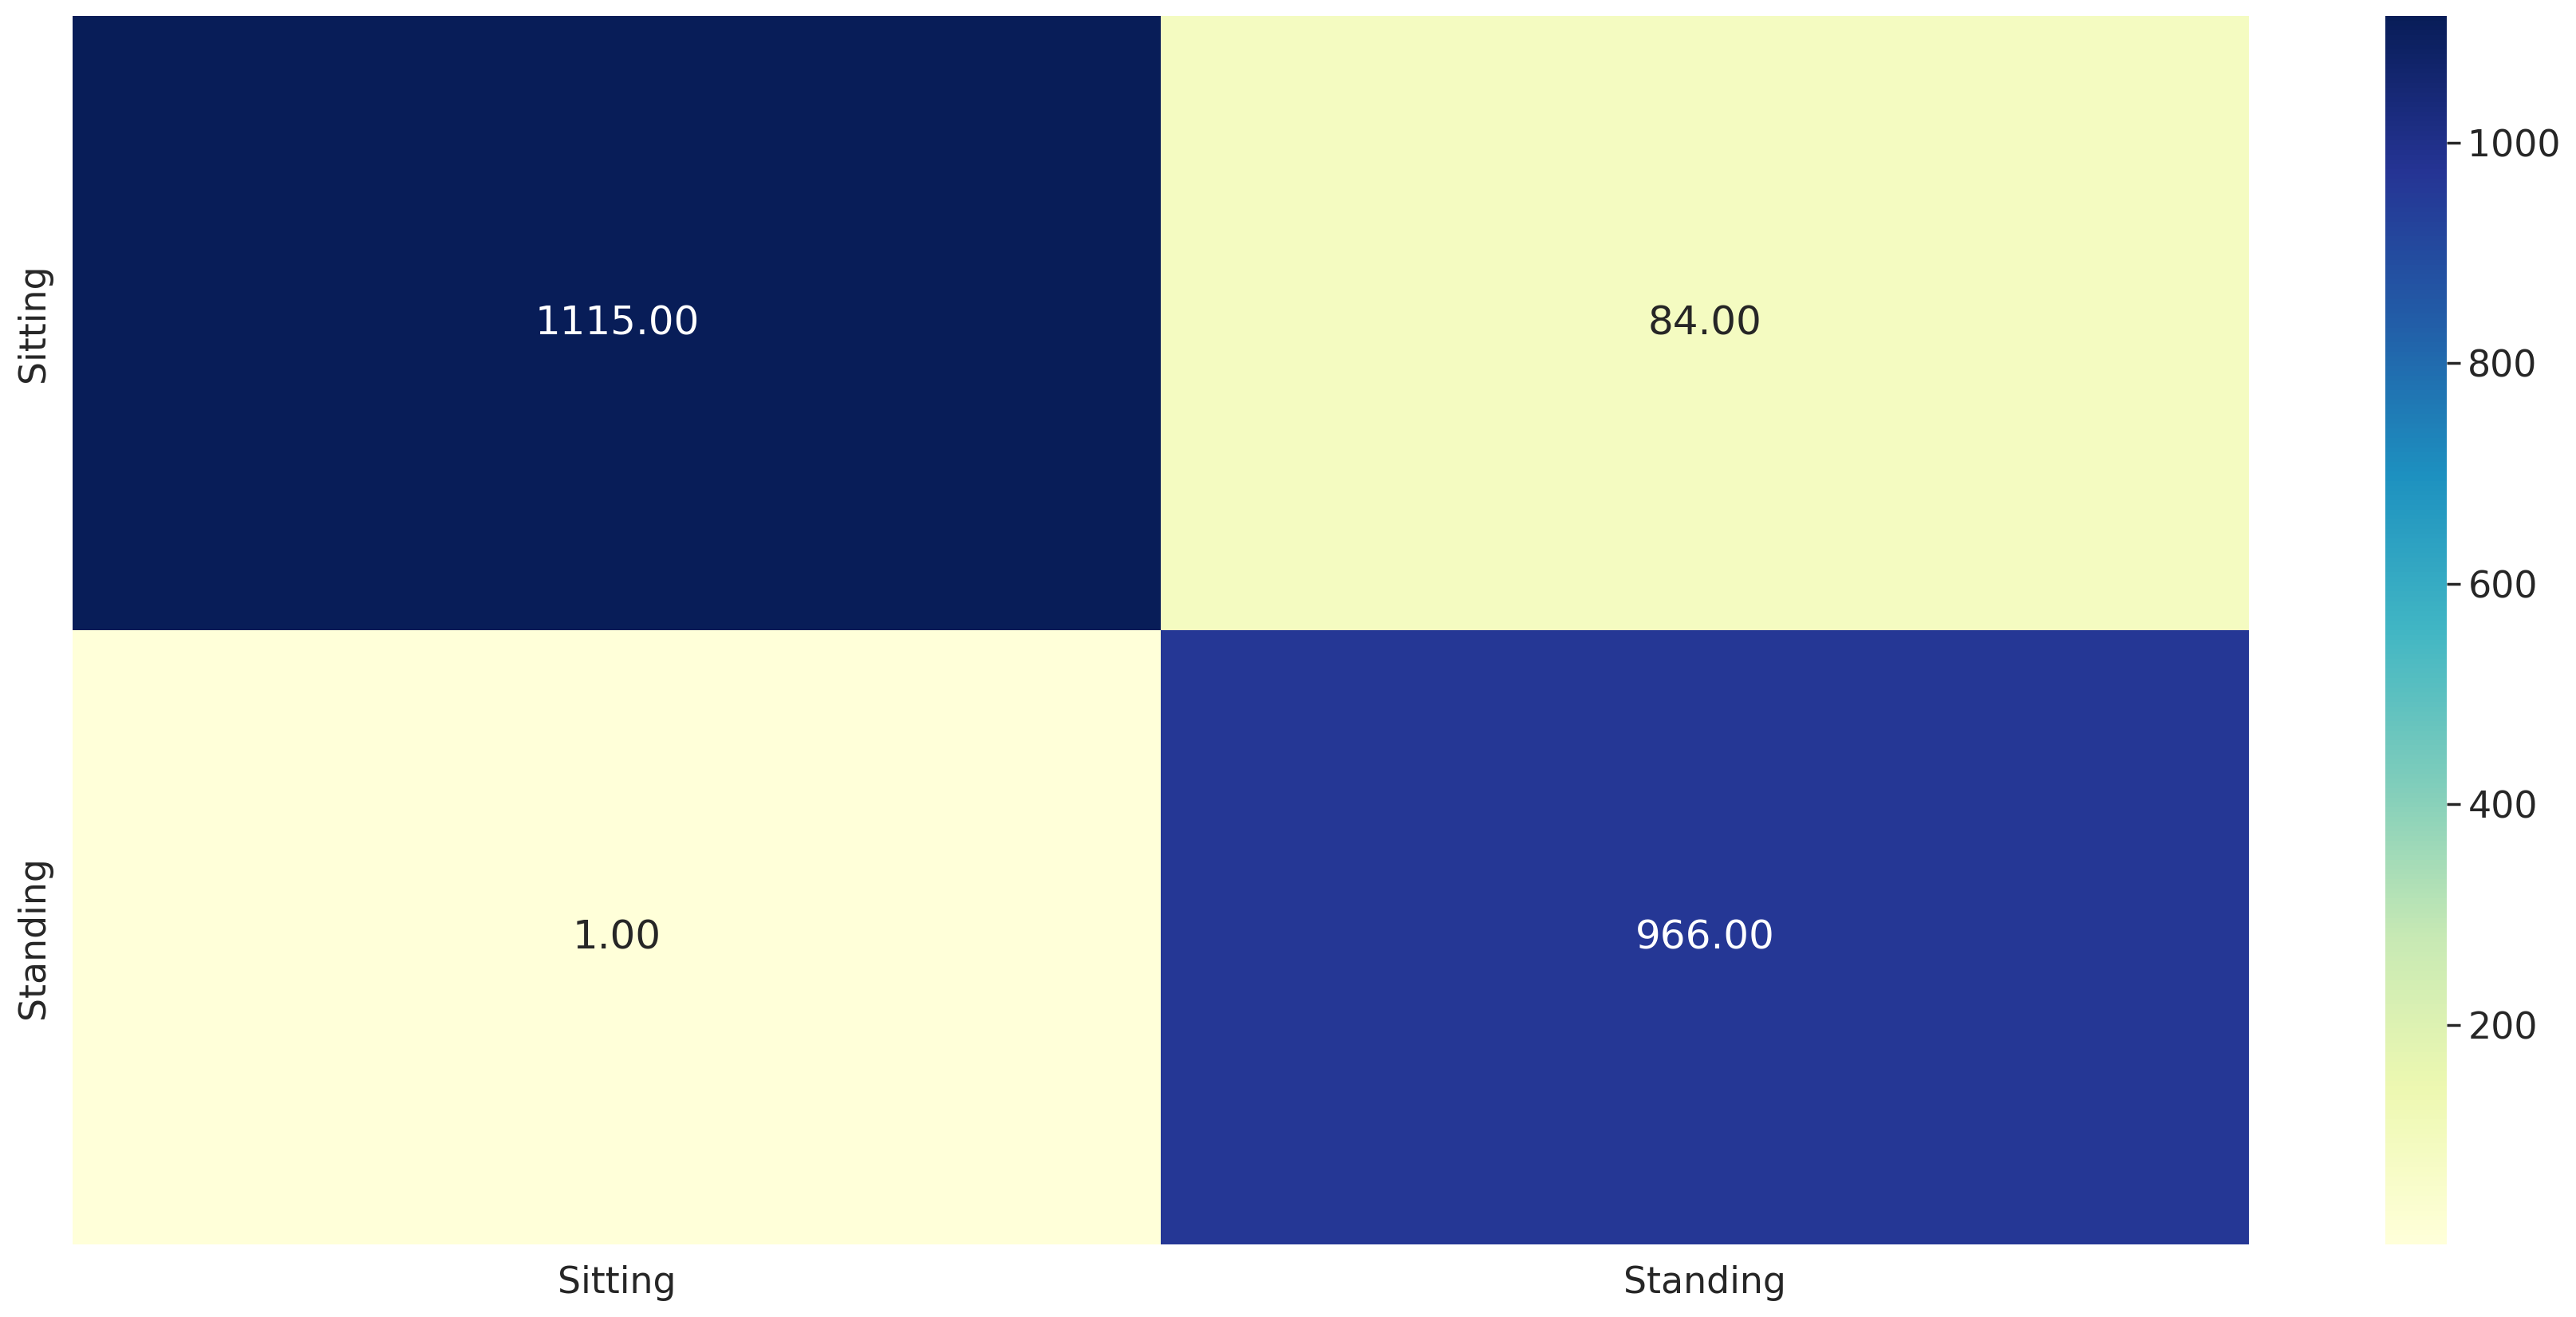

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = [ 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM3

In [ ]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))

model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 50, 128)           67584     
                                                                 
 dropout_15 (Dropout)        (None, 50, 128)           0         
                                                                 
 lstm_16 (LSTM)              (None, 50, 128)           131584    
                                                                 
 dropout_16 (Dropout)        (None, 50, 128)           0         
                                                                 
 lstm_17 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 64)               

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
55/55 [==============================] - 9s 44ms/step - loss: 0.1570 - accuracy: 0.9468 - val_loss: 0.1222 - val_accuracy: 0.9631
Epoch 2/10
55/55 [==============================] - 1s 15ms/step - loss: 0.0952 - accuracy: 0.9608 - val_loss: 0.0988 - val_accuracy: 0.9700
Epoch 3/10
55/55 [==============================] - 1s 15ms/step - loss: 0.0921 - accuracy: 0.9618 - val_loss: 0.1140 - val_accuracy: 0.9515
Epoch 4/10
55/55 [==============================] - 1s 15ms/step - loss: 0.0870 - accuracy: 0.9605 - val_loss: 0.1648 - val_accuracy: 0.9290
Epoch 5/10
55/55 [==============================] - 1s 15ms/step - loss: 0.1366 - accuracy: 0.9449 - val_loss: 0.1531 - val_accuracy: 0.9371
Epoch 6/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1002 - accuracy: 0.9488 - val_loss: 0.1137 - val_accuracy: 0.9515
Epoch 7/10
55/55 [==============================] - 1s 15ms/step - loss: 0.1039 - accuracy: 0.9514 - val_loss: 0.1210 - val_accuracy: 0.9596
Epoch 8/10
55

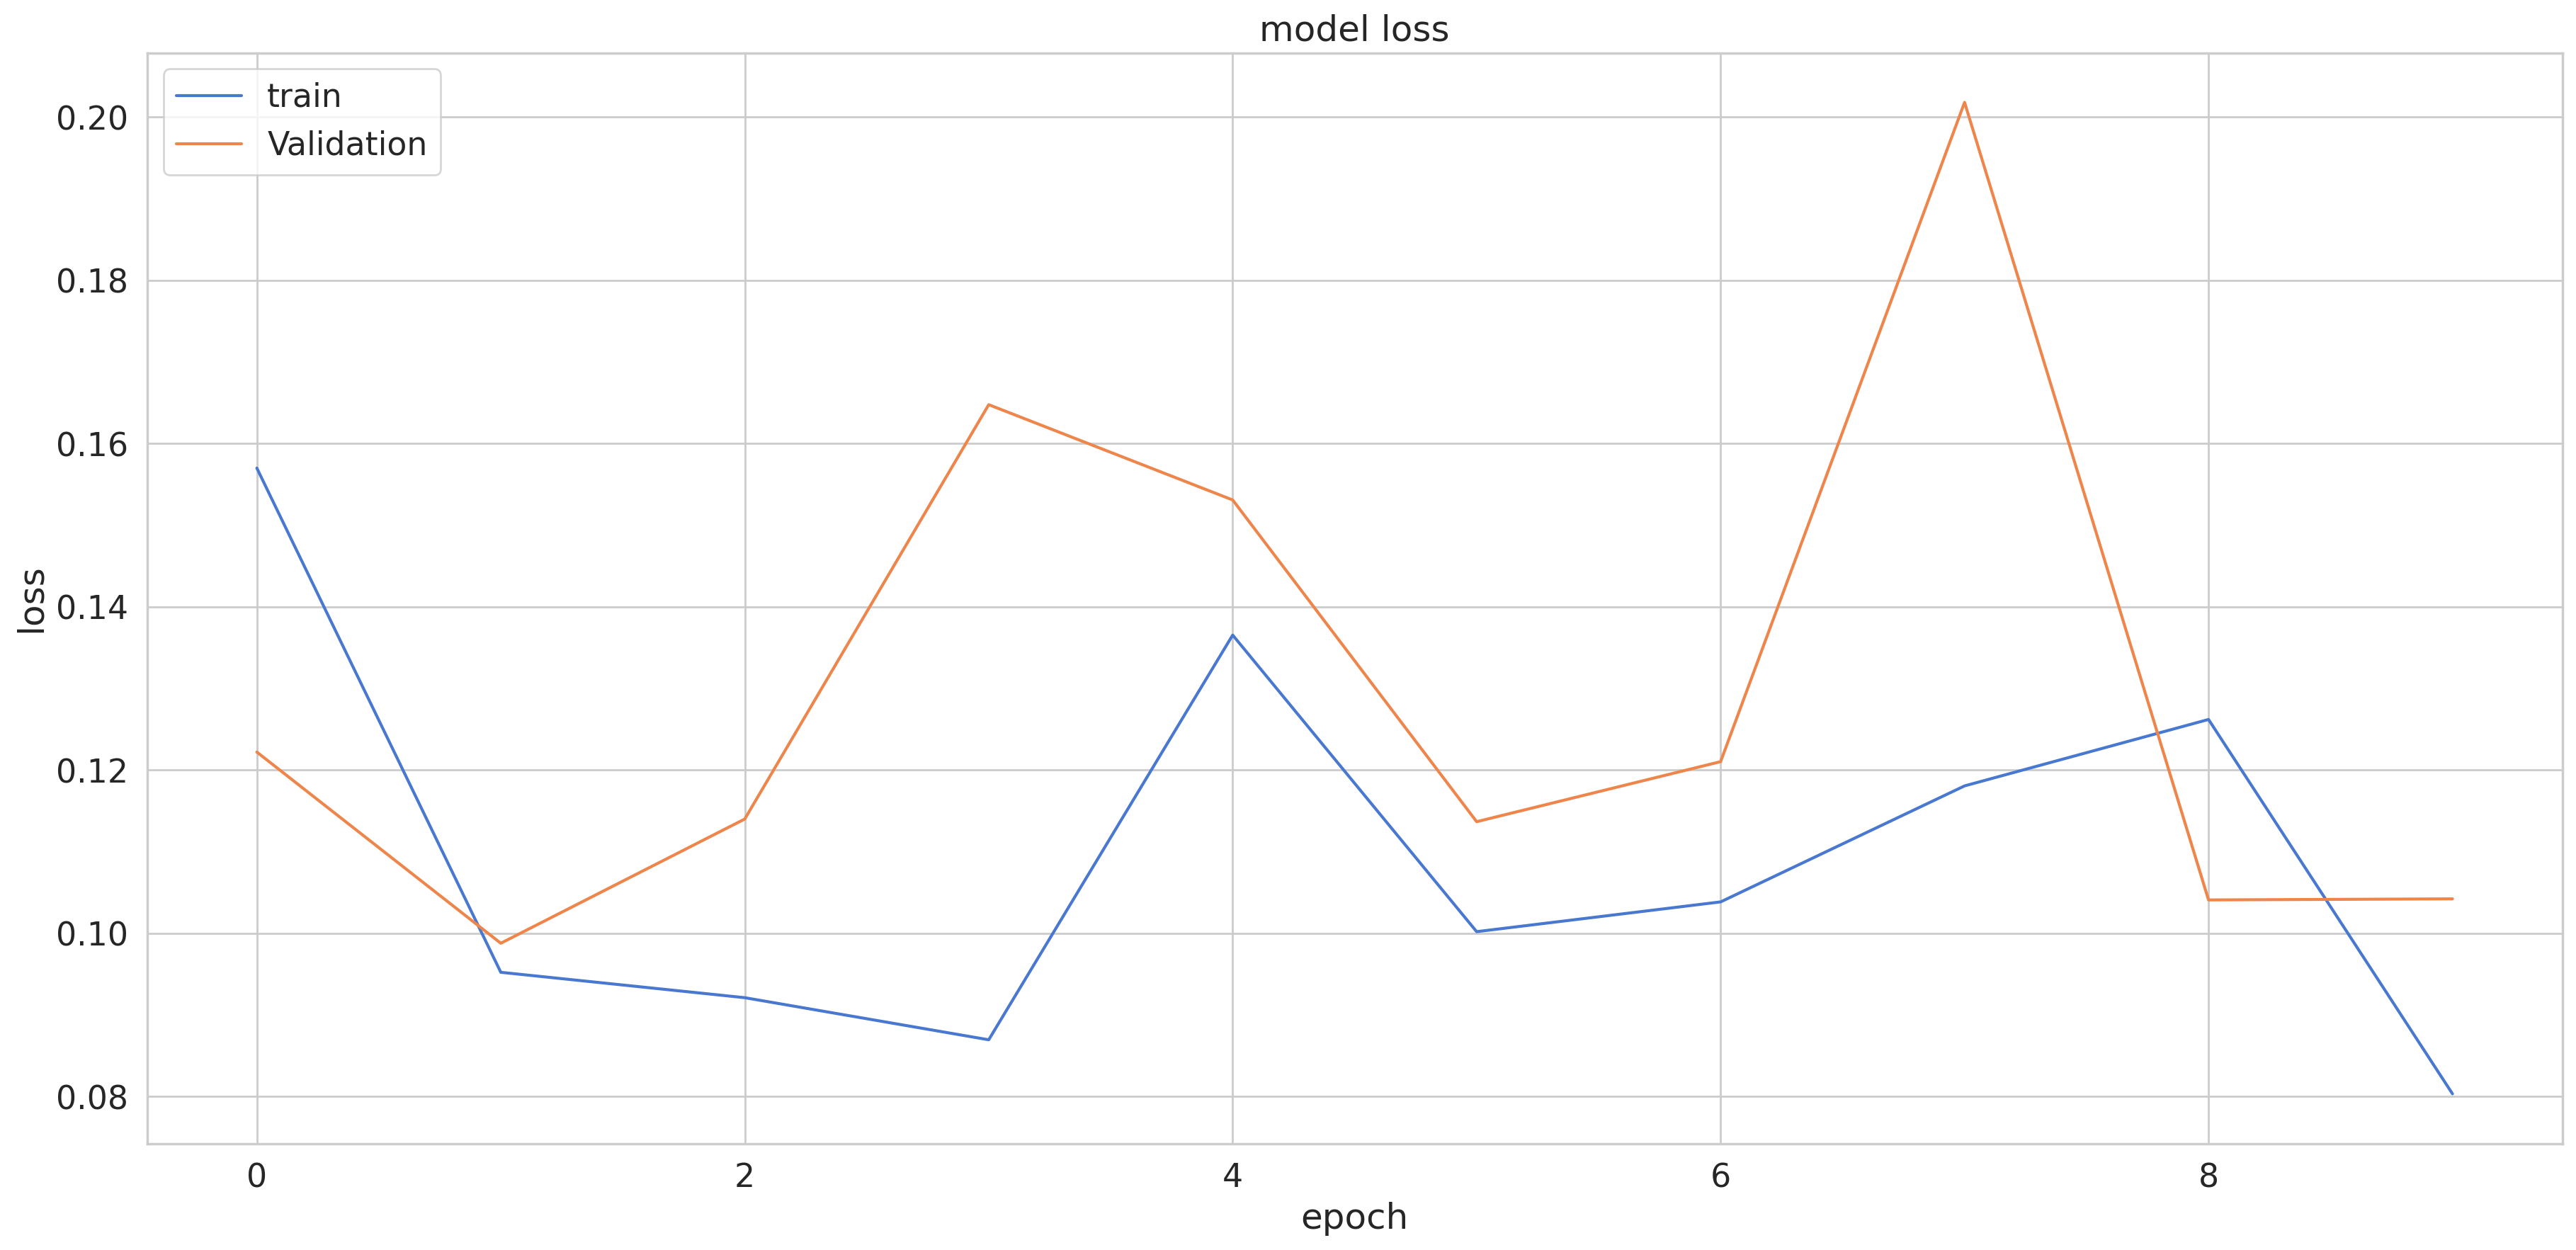

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

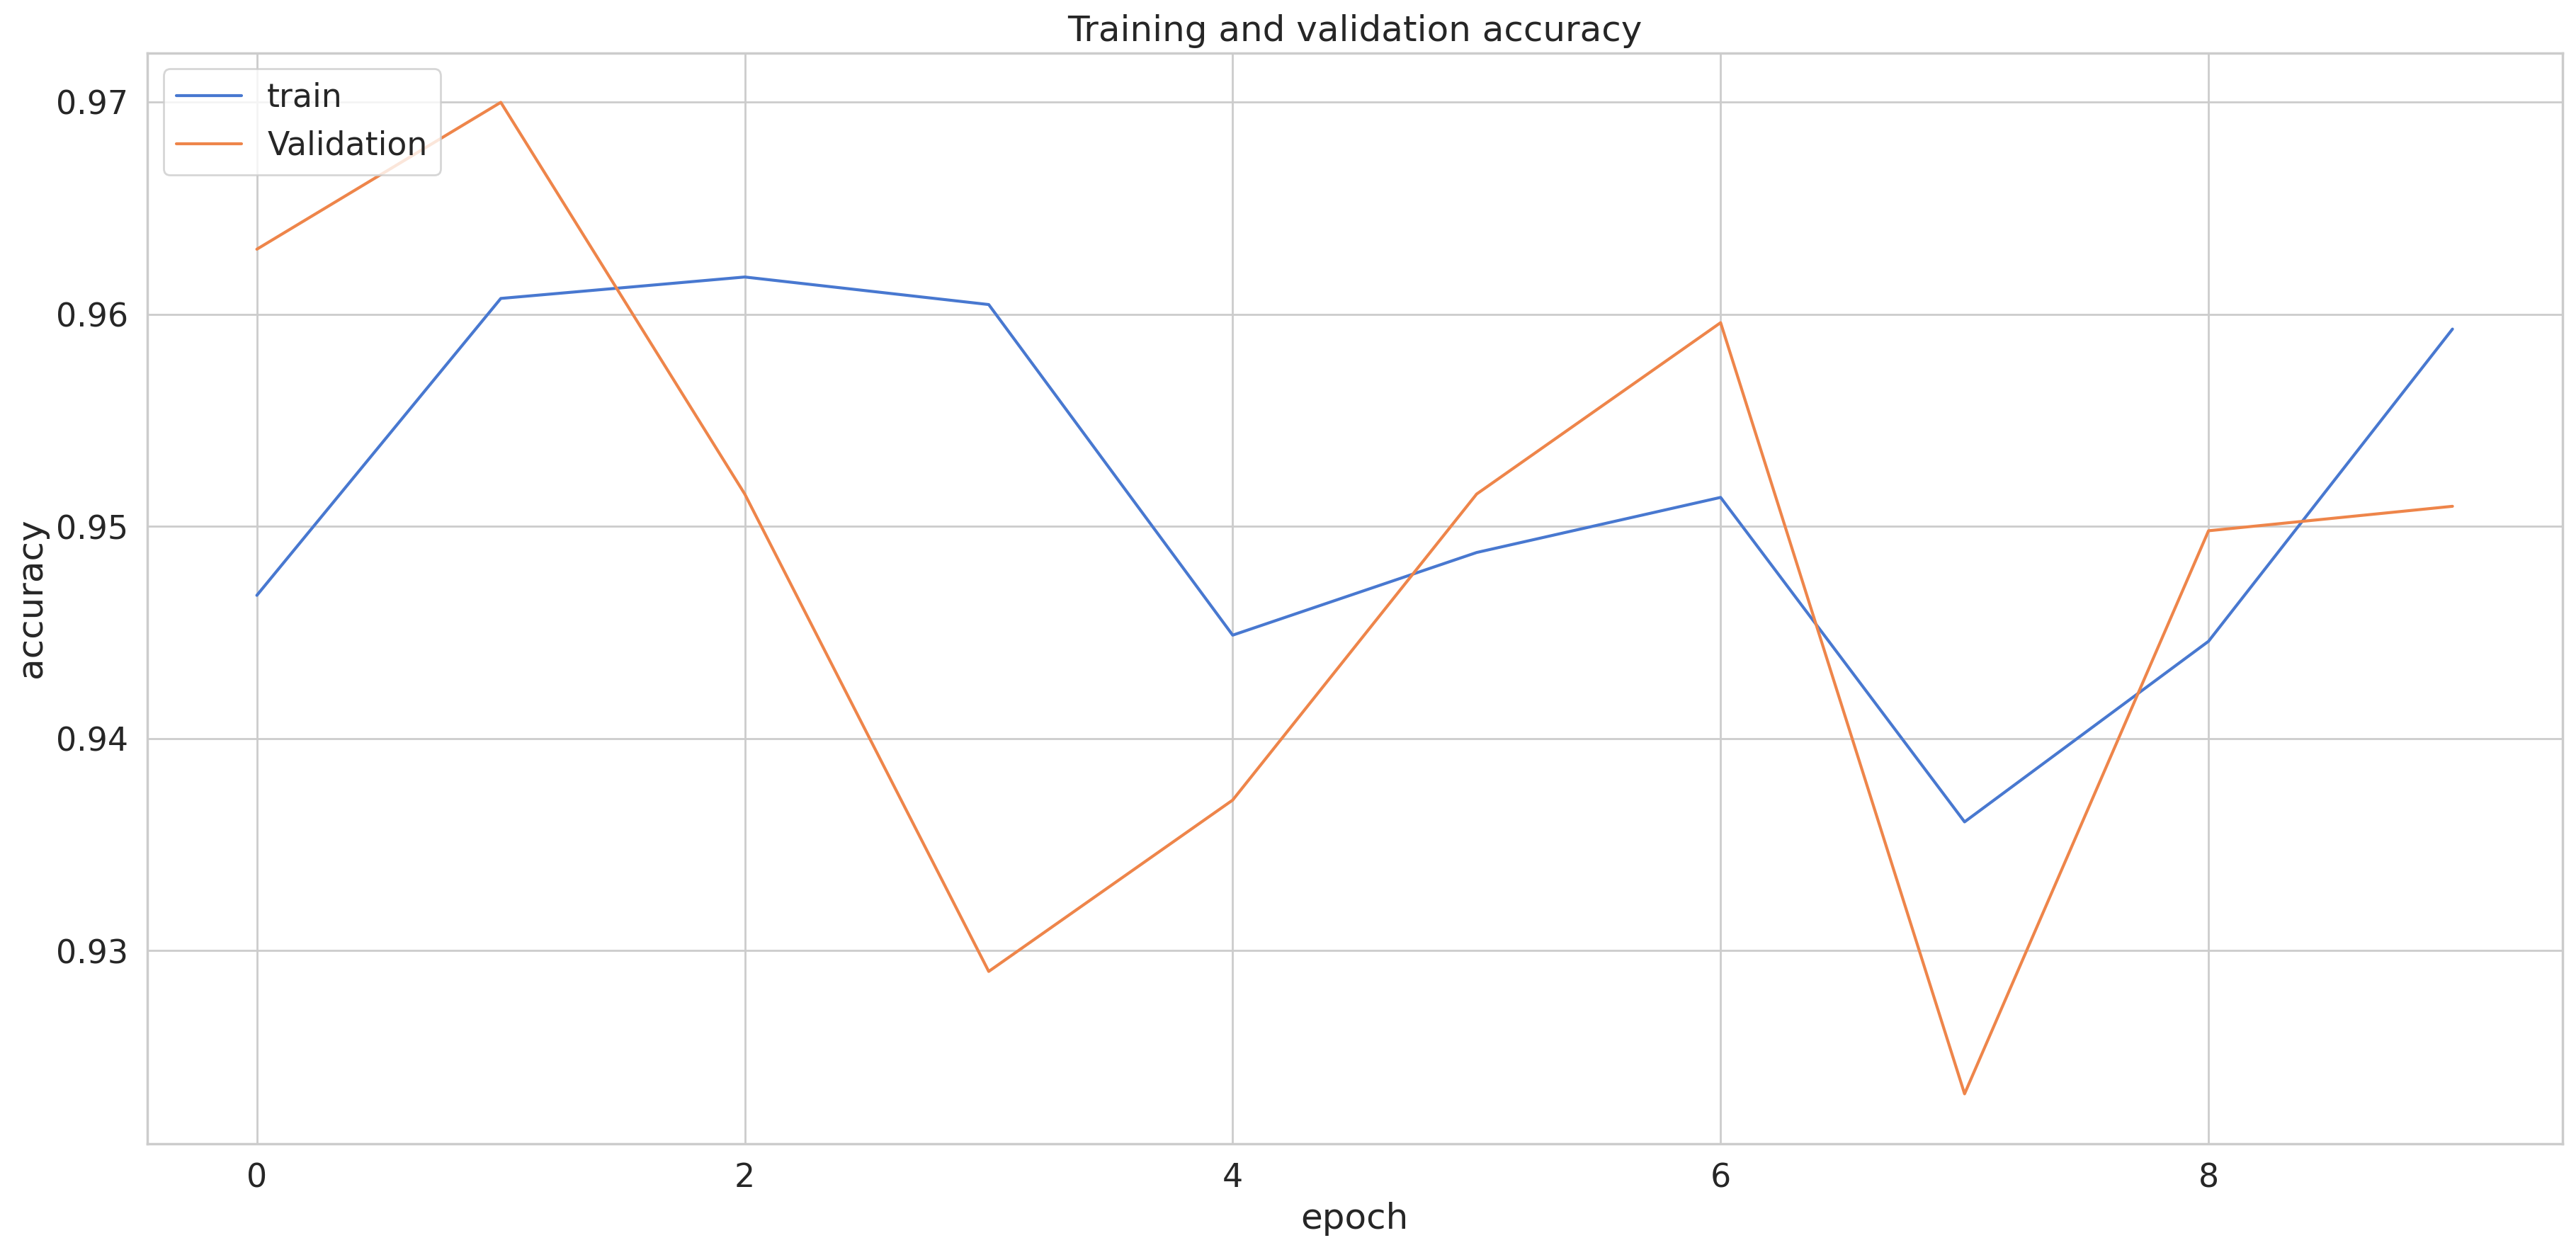

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

68/68 [==============================] - 1s 5ms/step
f1_score =  0.9613220835359253
0.961218836565097
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1199
           1       0.92      1.00      0.96       967

    accuracy                           0.96      2166
   macro avg       0.96      0.96      0.96      2166
weighted avg       0.96      0.96      0.96      2166



<Axes: >

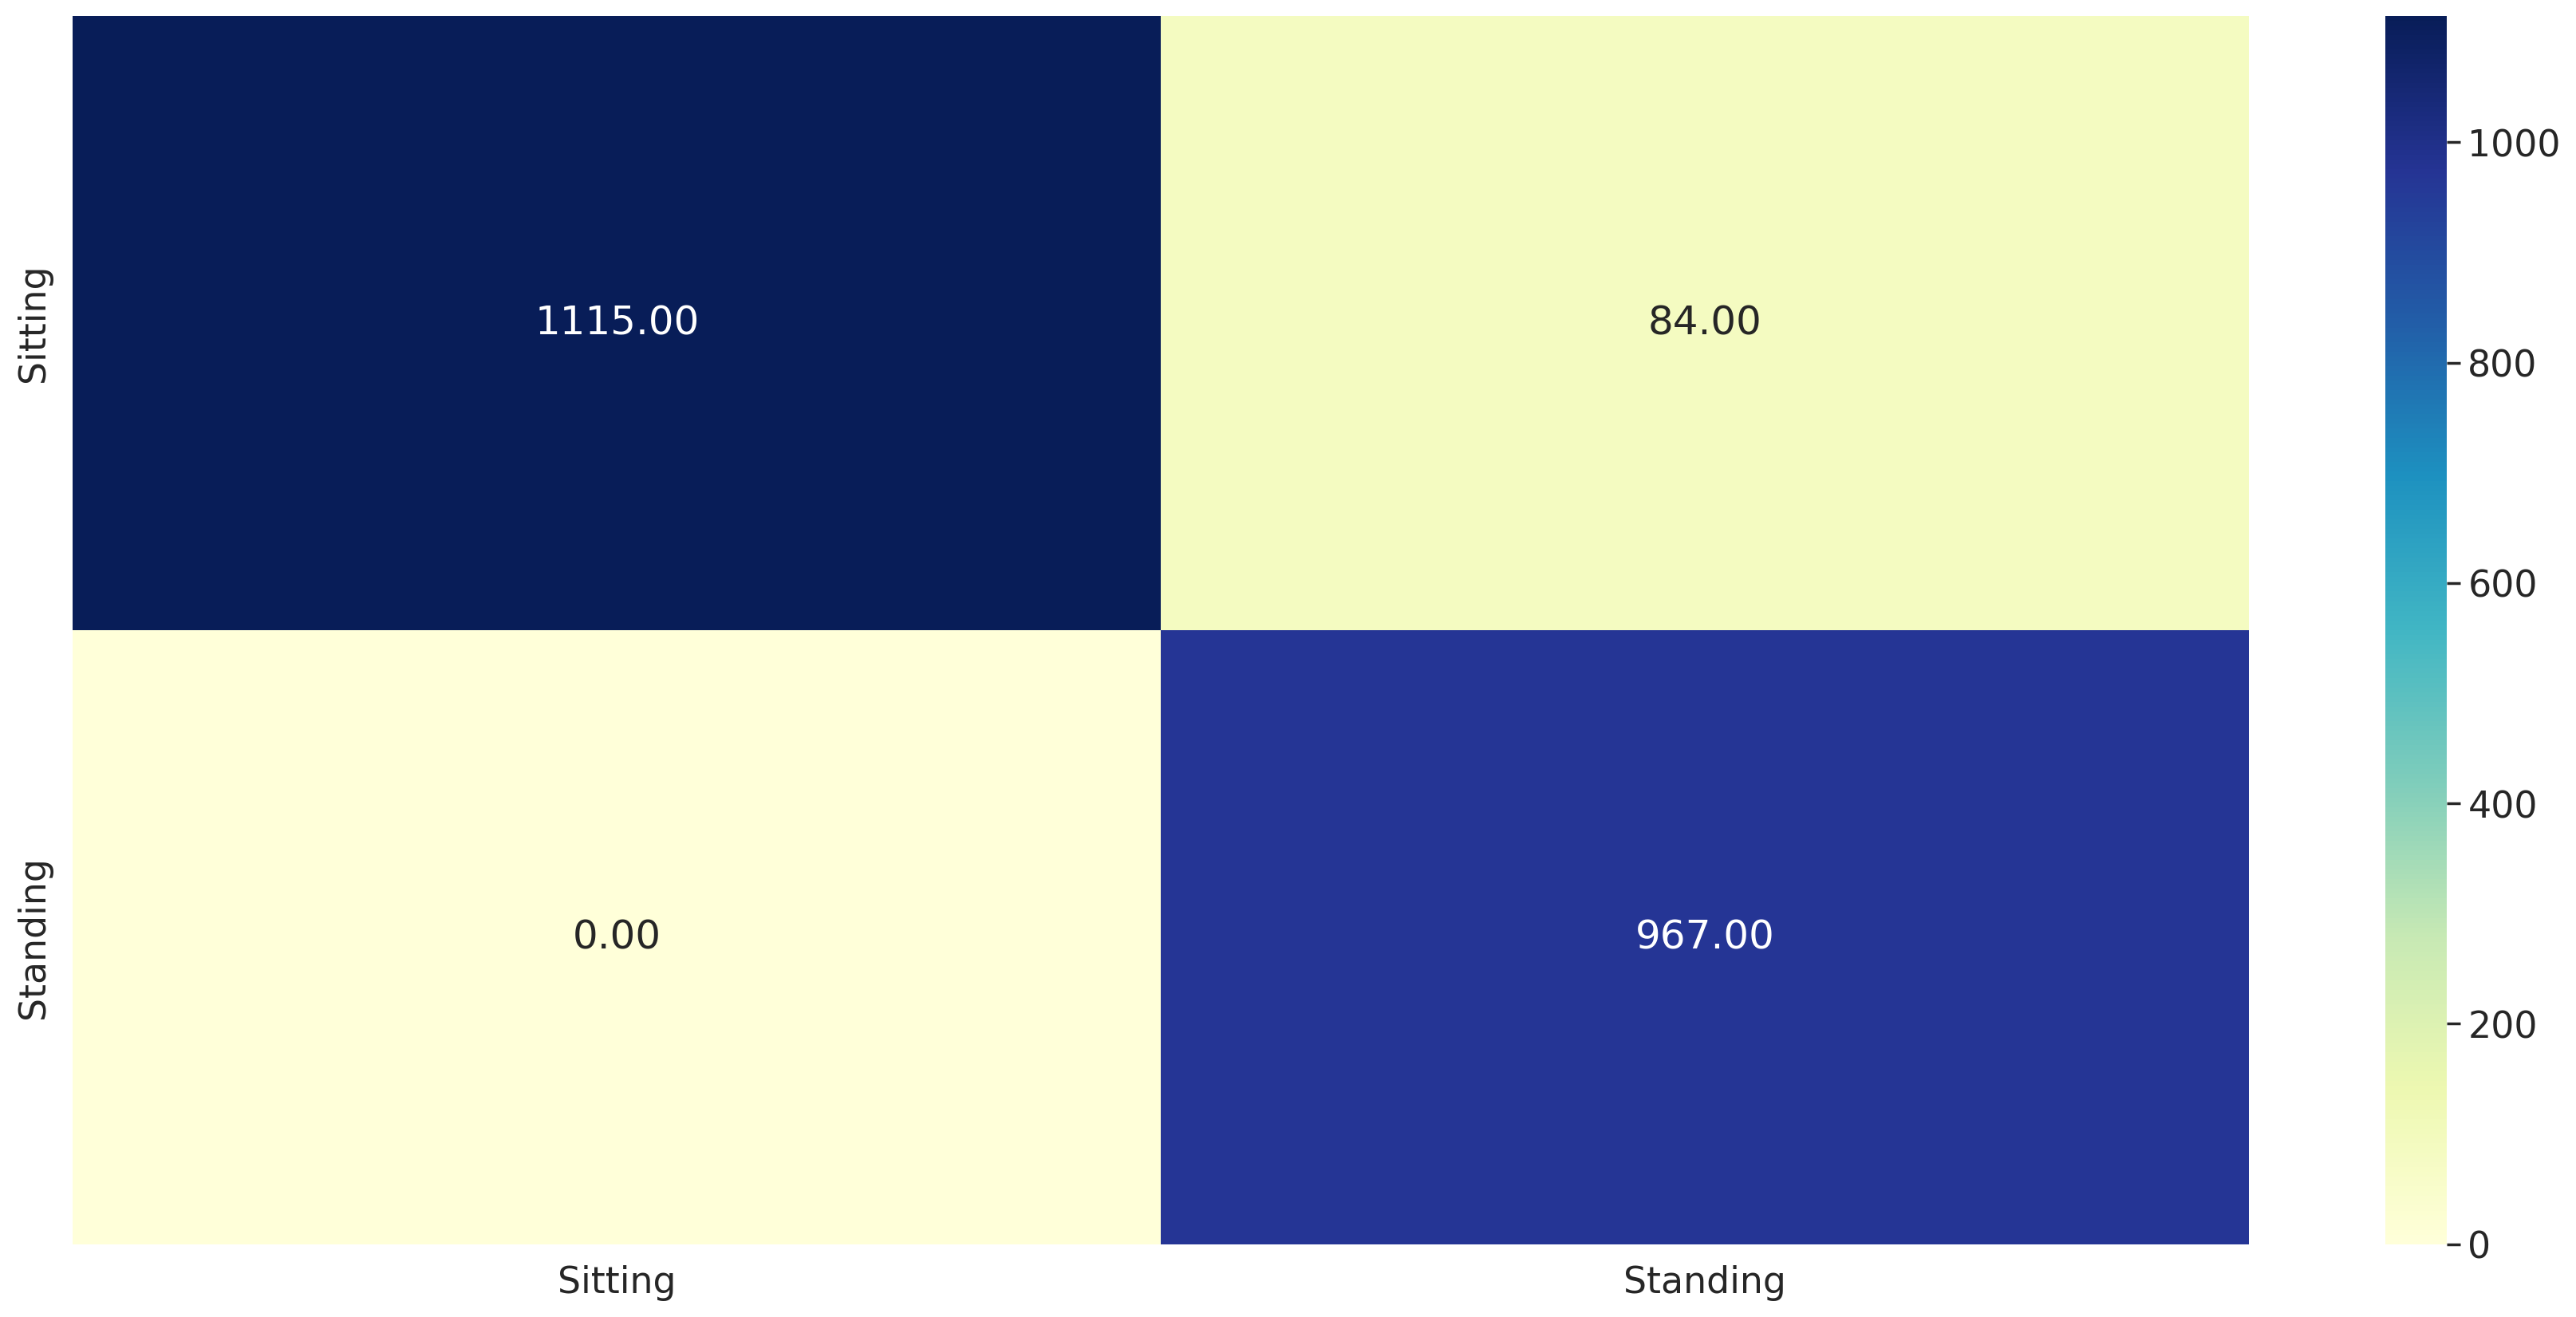

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = [ 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM4

In [ ]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))

model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 50, 128)           67584     
                                                                 
 dropout_18 (Dropout)        (None, 50, 128)           0         
                                                                 
 lstm_19 (LSTM)              (None, 50, 128)           131584    
                                                                 
 dropout_19 (Dropout)        (None, 50, 128)           0         
                                                                 
 lstm_20 (LSTM)              (None, 50, 128)           131584    
                                                                 
 dropout_20 (Dropout)        (None, 50, 128)           0         
                                                                 
 lstm_21 (LSTM)              (None, 128)              

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
55/55 [==============================] - 12s 47ms/step - loss: 0.1564 - accuracy: 0.9479 - val_loss: 0.1073 - val_accuracy: 0.9521
Epoch 2/10
55/55 [==============================] - 1s 18ms/step - loss: 0.0965 - accuracy: 0.9540 - val_loss: 0.1774 - val_accuracy: 0.8604
Epoch 3/10
55/55 [==============================] - 1s 19ms/step - loss: 0.1069 - accuracy: 0.9525 - val_loss: 0.1374 - val_accuracy: 0.9498
Epoch 4/10
55/55 [==============================] - 1s 19ms/step - loss: 0.0901 - accuracy: 0.9608 - val_loss: 0.1192 - val_accuracy: 0.9504
Epoch 5/10
55/55 [==============================] - 1s 19ms/step - loss: 0.1322 - accuracy: 0.9430 - val_loss: 0.1478 - val_accuracy: 0.9573
Epoch 6/10
55/55 [==============================] - 1s 21ms/step - loss: 0.1350 - accuracy: 0.9544 - val_loss: 0.1440 - val_accuracy: 0.9527
Epoch 7/10
55/55 [==============================] - 1s 22ms/step - loss: 0.1074 - accuracy: 0.9569 - val_loss: 0.1232 - val_accuracy: 0.9533
Epoch 8/10
5

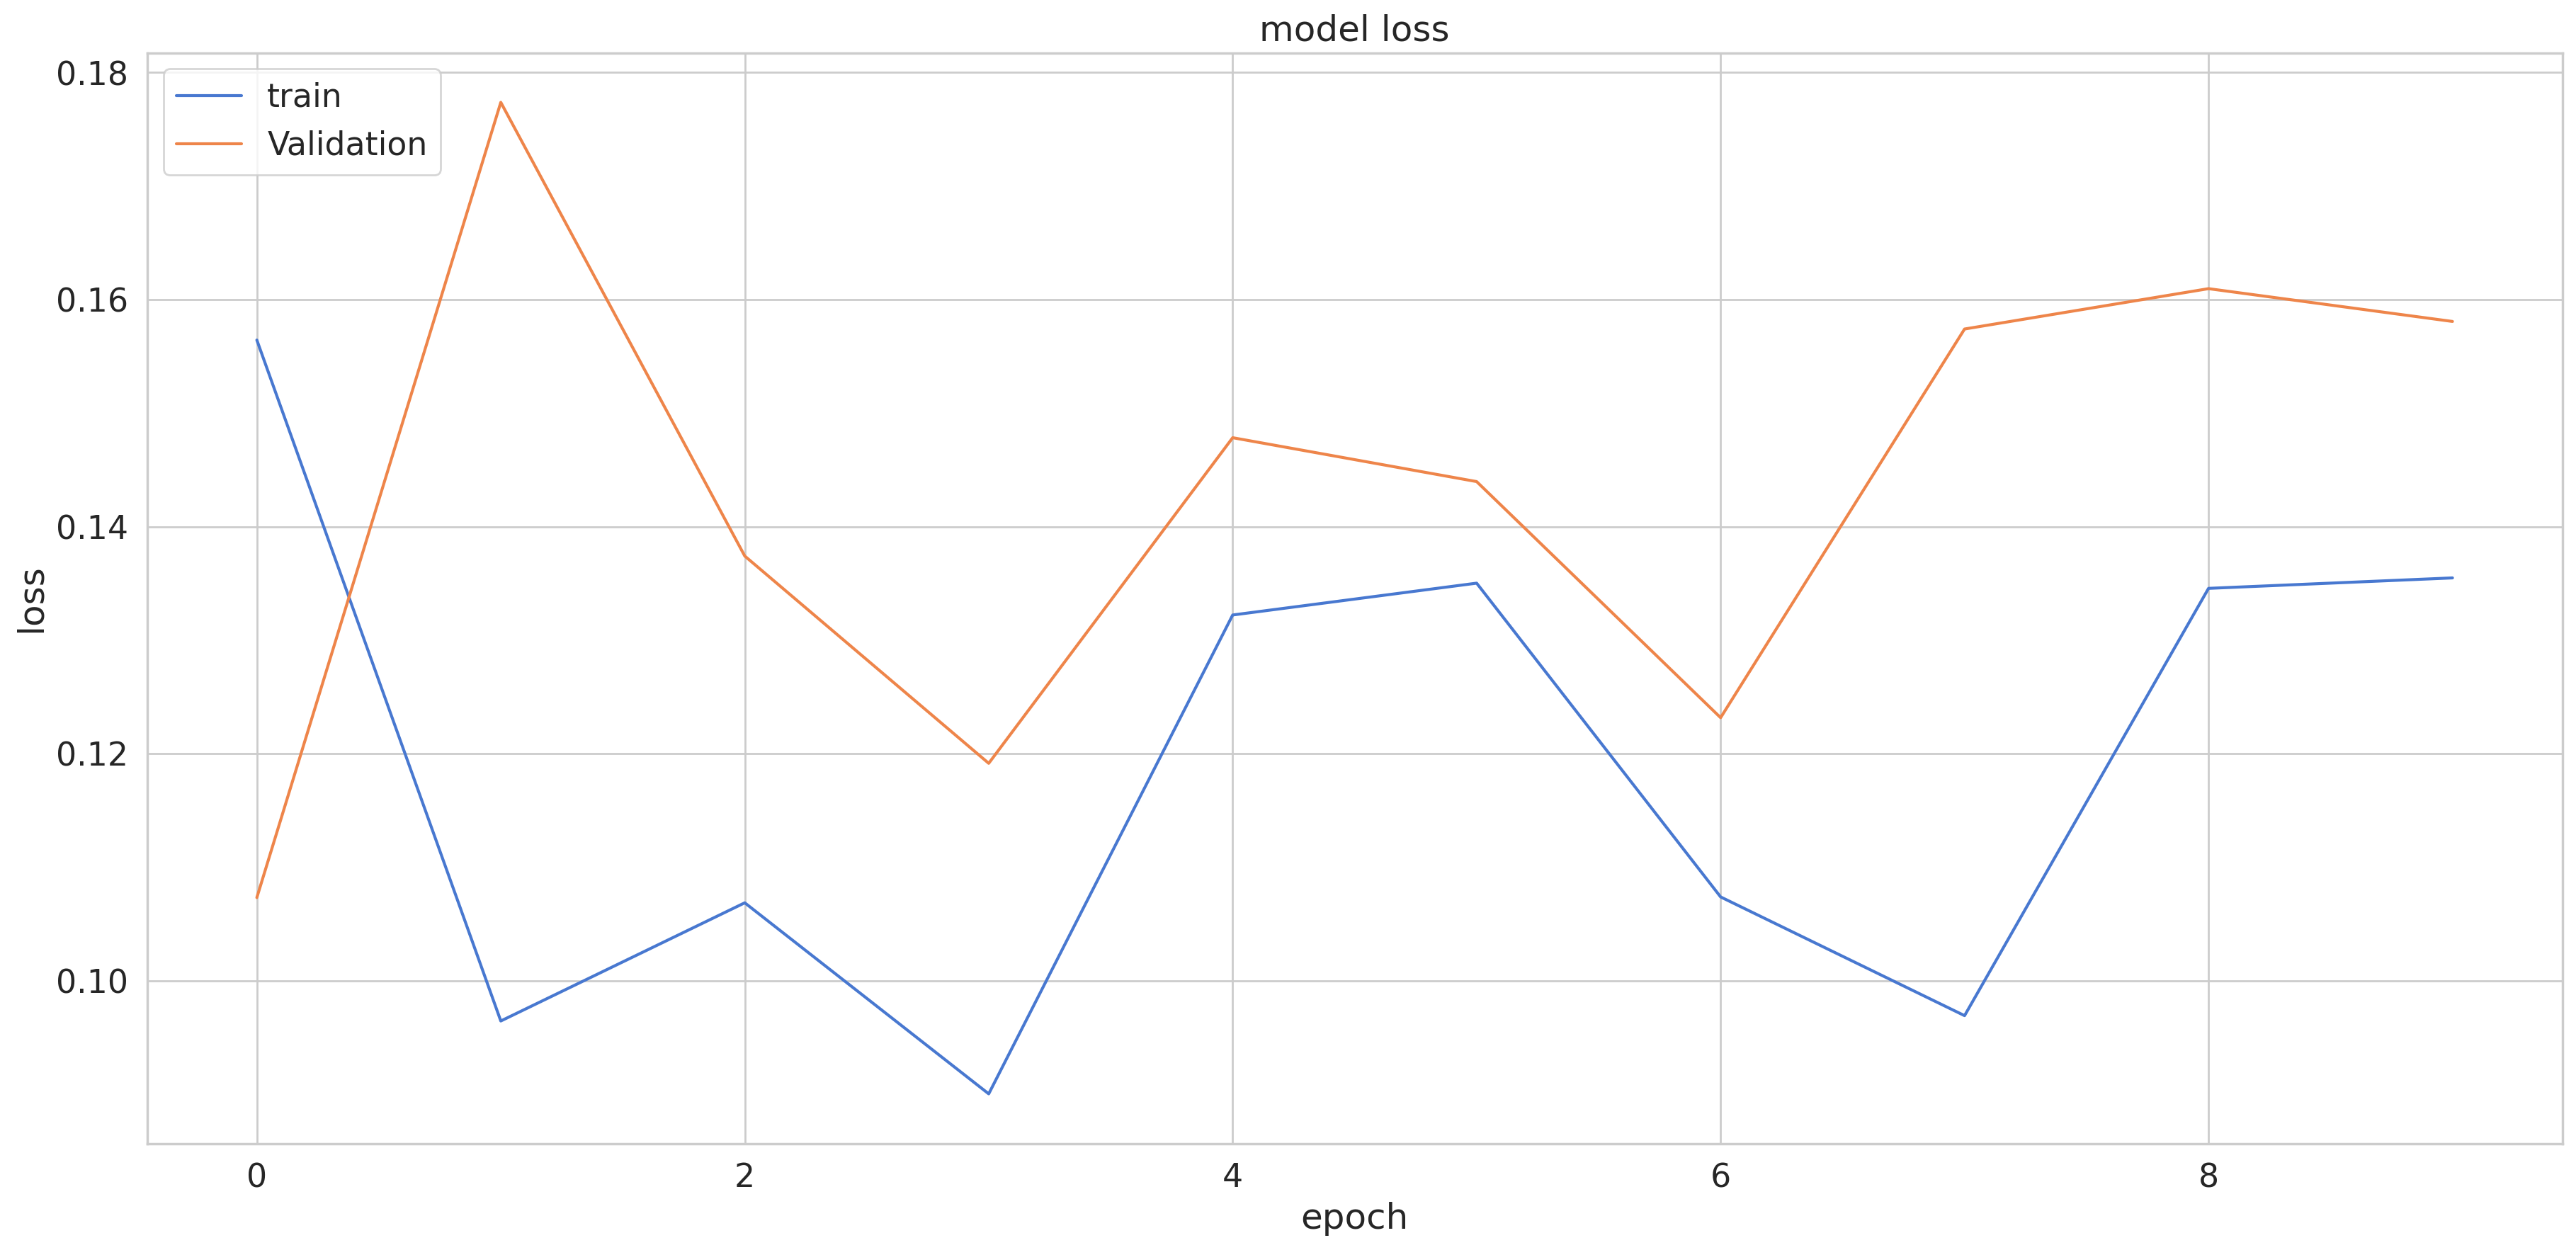

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

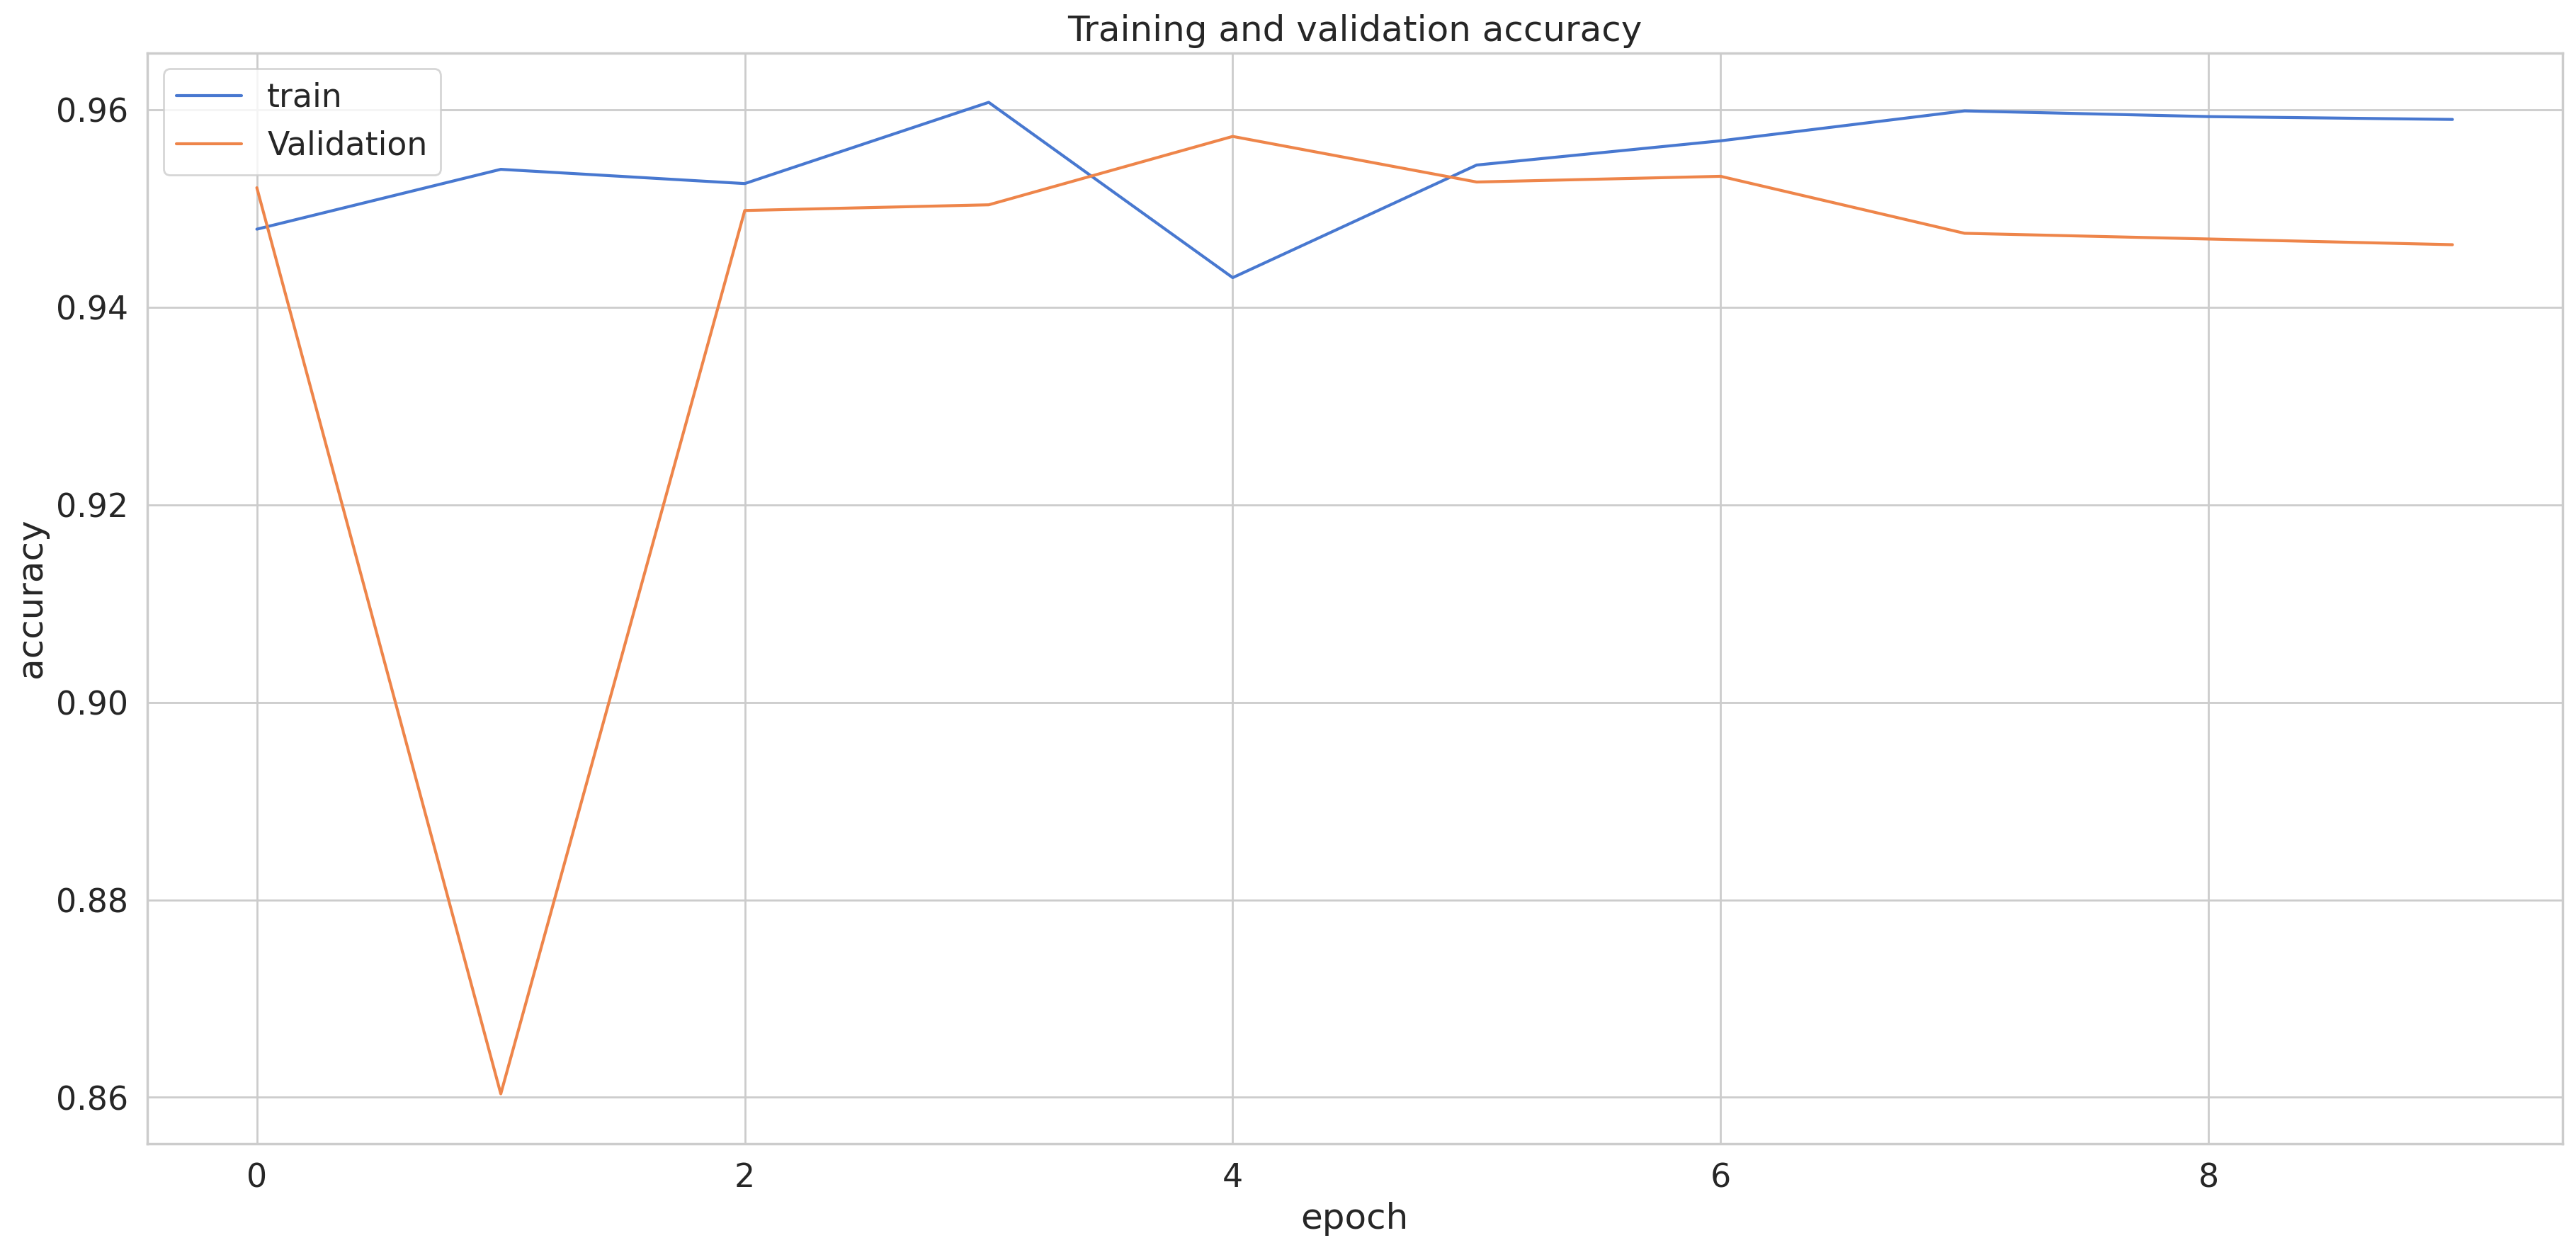

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

68/68 [==============================] - 2s 6ms/step
f1_score =  0.9580983461018534
0.9579870729455217
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1199
           1       0.92      1.00      0.95       967

    accuracy                           0.96      2166
   macro avg       0.96      0.96      0.96      2166
weighted avg       0.96      0.96      0.96      2166



<Axes: >

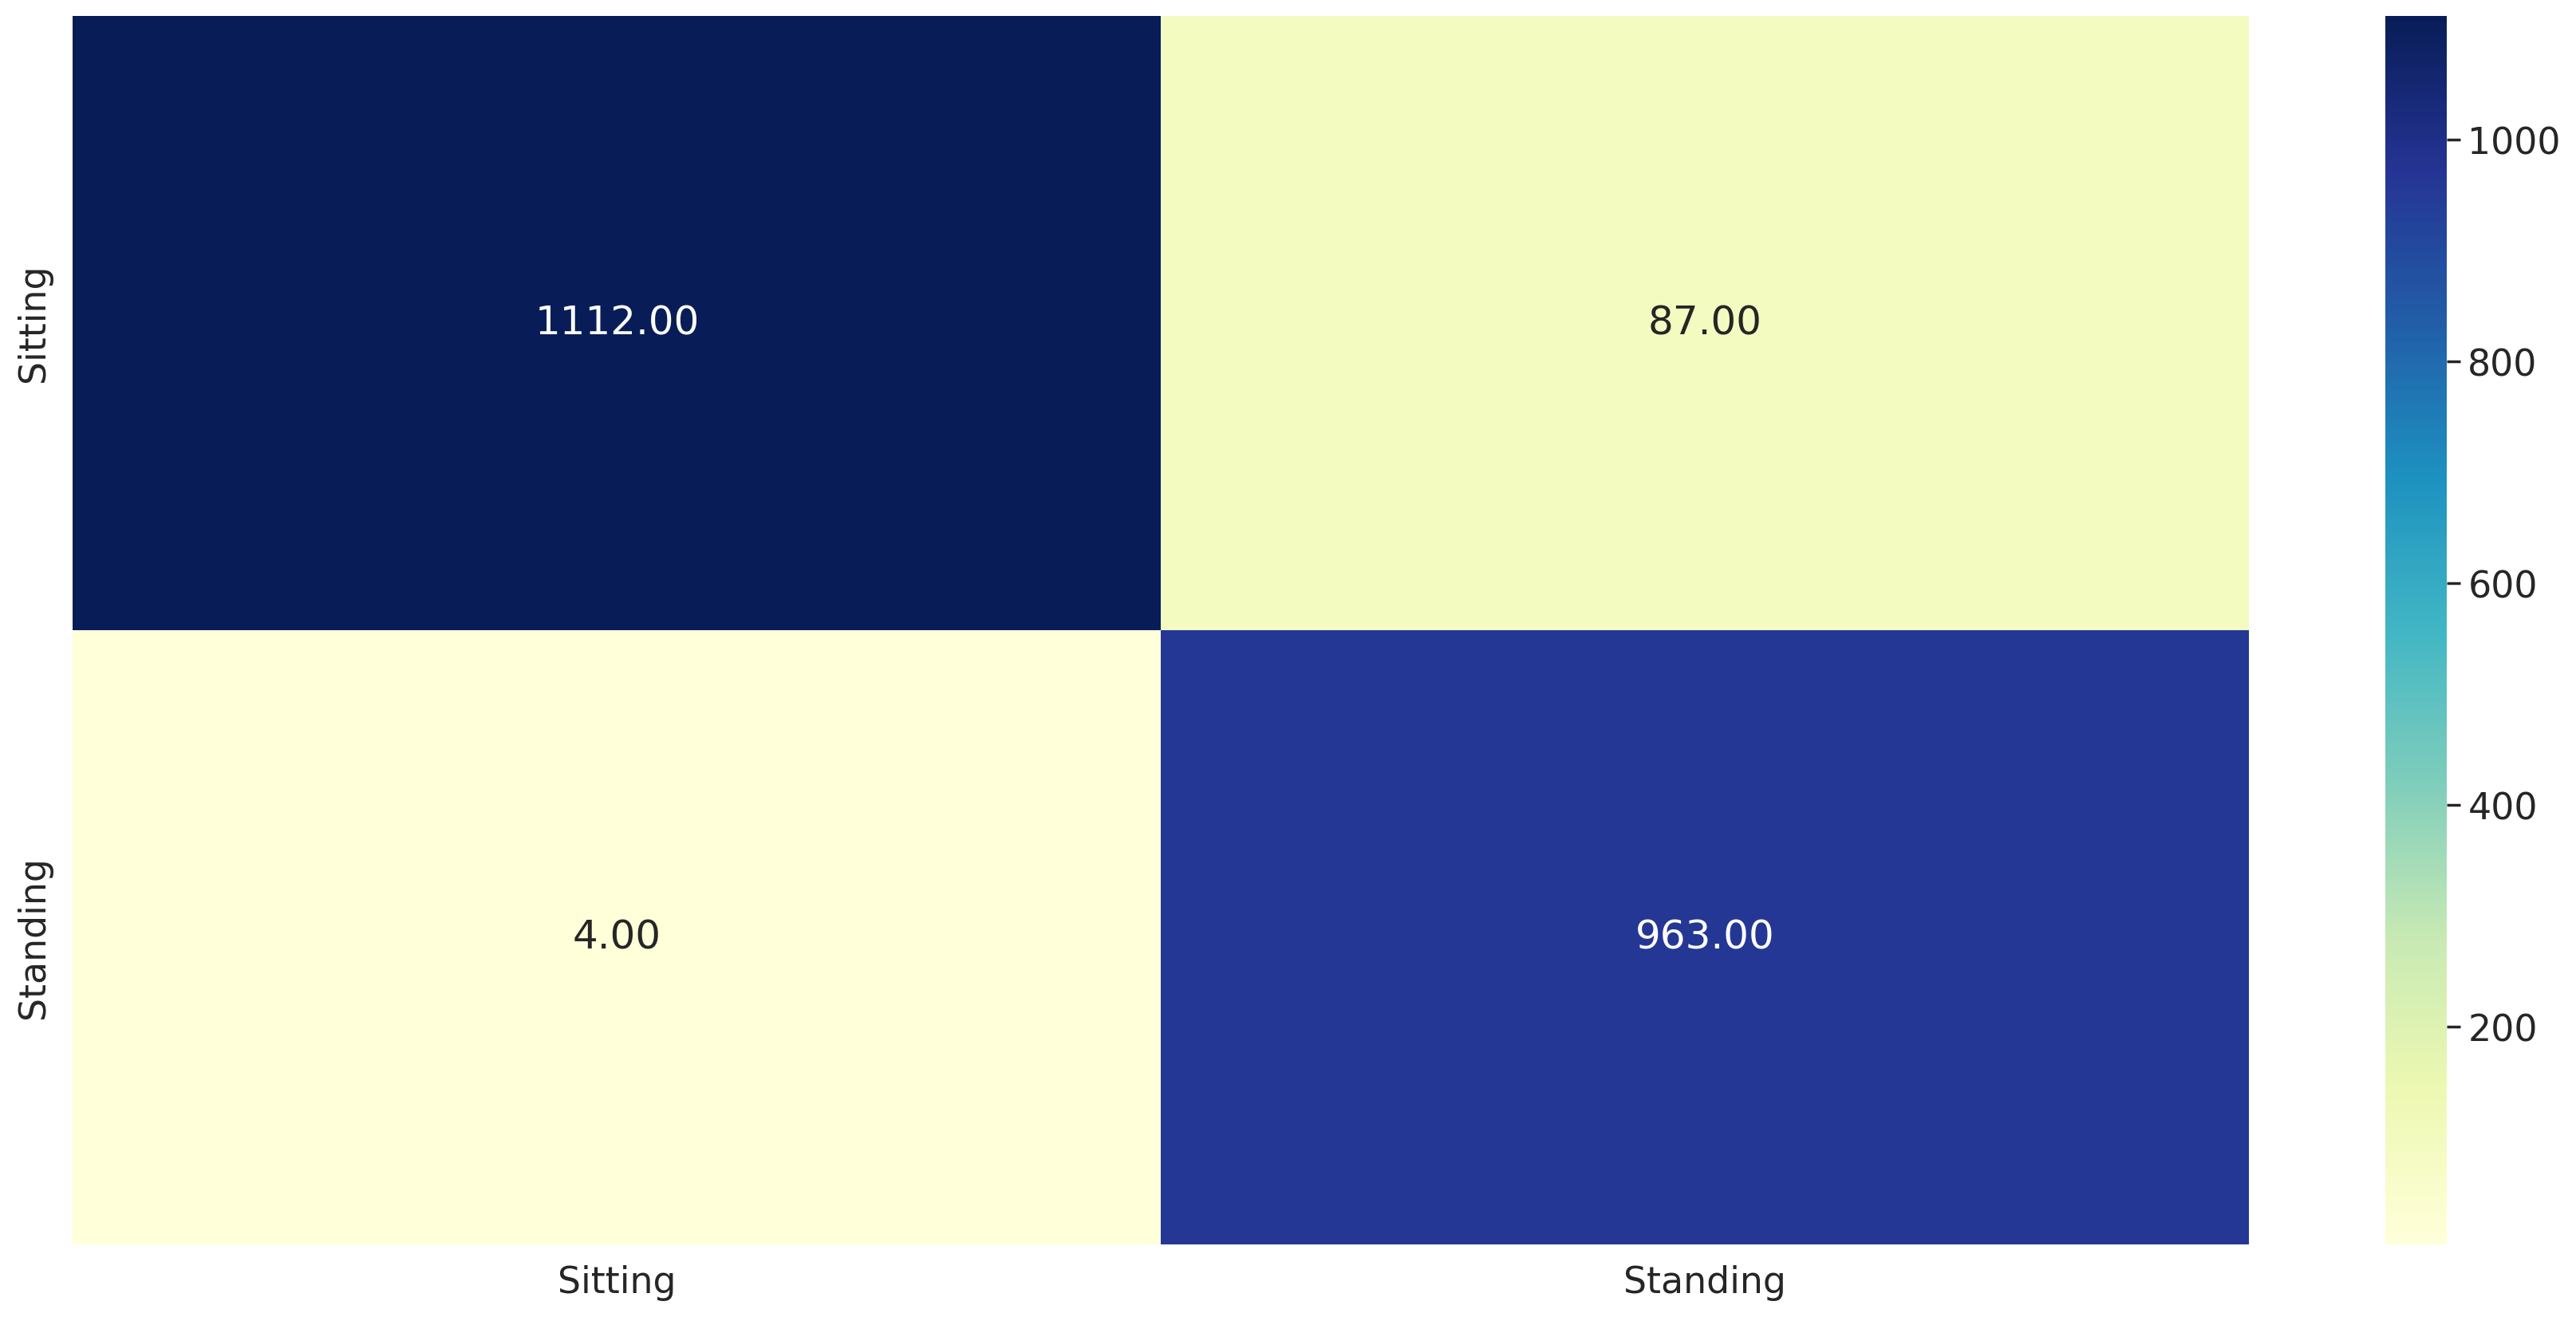

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = [ 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM5

In [15]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))

model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 128)           67584     
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 128)           131584    
                                                                 
 dropout_2 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50, 128)           1

In [16]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
55/55 [==============================] - 14s 60ms/step - loss: 0.1928 - accuracy: 0.9440 - val_loss: 0.1452 - val_accuracy: 0.9475
Epoch 2/10
55/55 [==============================] - 1s 22ms/step - loss: 0.1121 - accuracy: 0.9590 - val_loss: 0.0988 - val_accuracy: 0.9602
Epoch 3/10
55/55 [==============================] - 1s 22ms/step - loss: 0.0954 - accuracy: 0.9603 - val_loss: 0.0880 - val_accuracy: 0.9602
Epoch 4/10
55/55 [==============================] - 1s 21ms/step - loss: 0.1175 - accuracy: 0.9501 - val_loss: 0.1548 - val_accuracy: 0.9590
Epoch 5/10
55/55 [==============================] - 1s 22ms/step - loss: 0.1403 - accuracy: 0.9579 - val_loss: 0.1396 - val_accuracy: 0.9602
Epoch 6/10
55/55 [==============================] - 1s 23ms/step - loss: 0.1410 - accuracy: 0.9599 - val_loss: 0.1382 - val_accuracy: 0.9602
Epoch 7/10
55/55 [==============================] - 1s 23ms/step - loss: 0.1382 - accuracy: 0.9609 - val_loss: 0.1396 - val_accuracy: 0.9602
Epoch 8/10
5

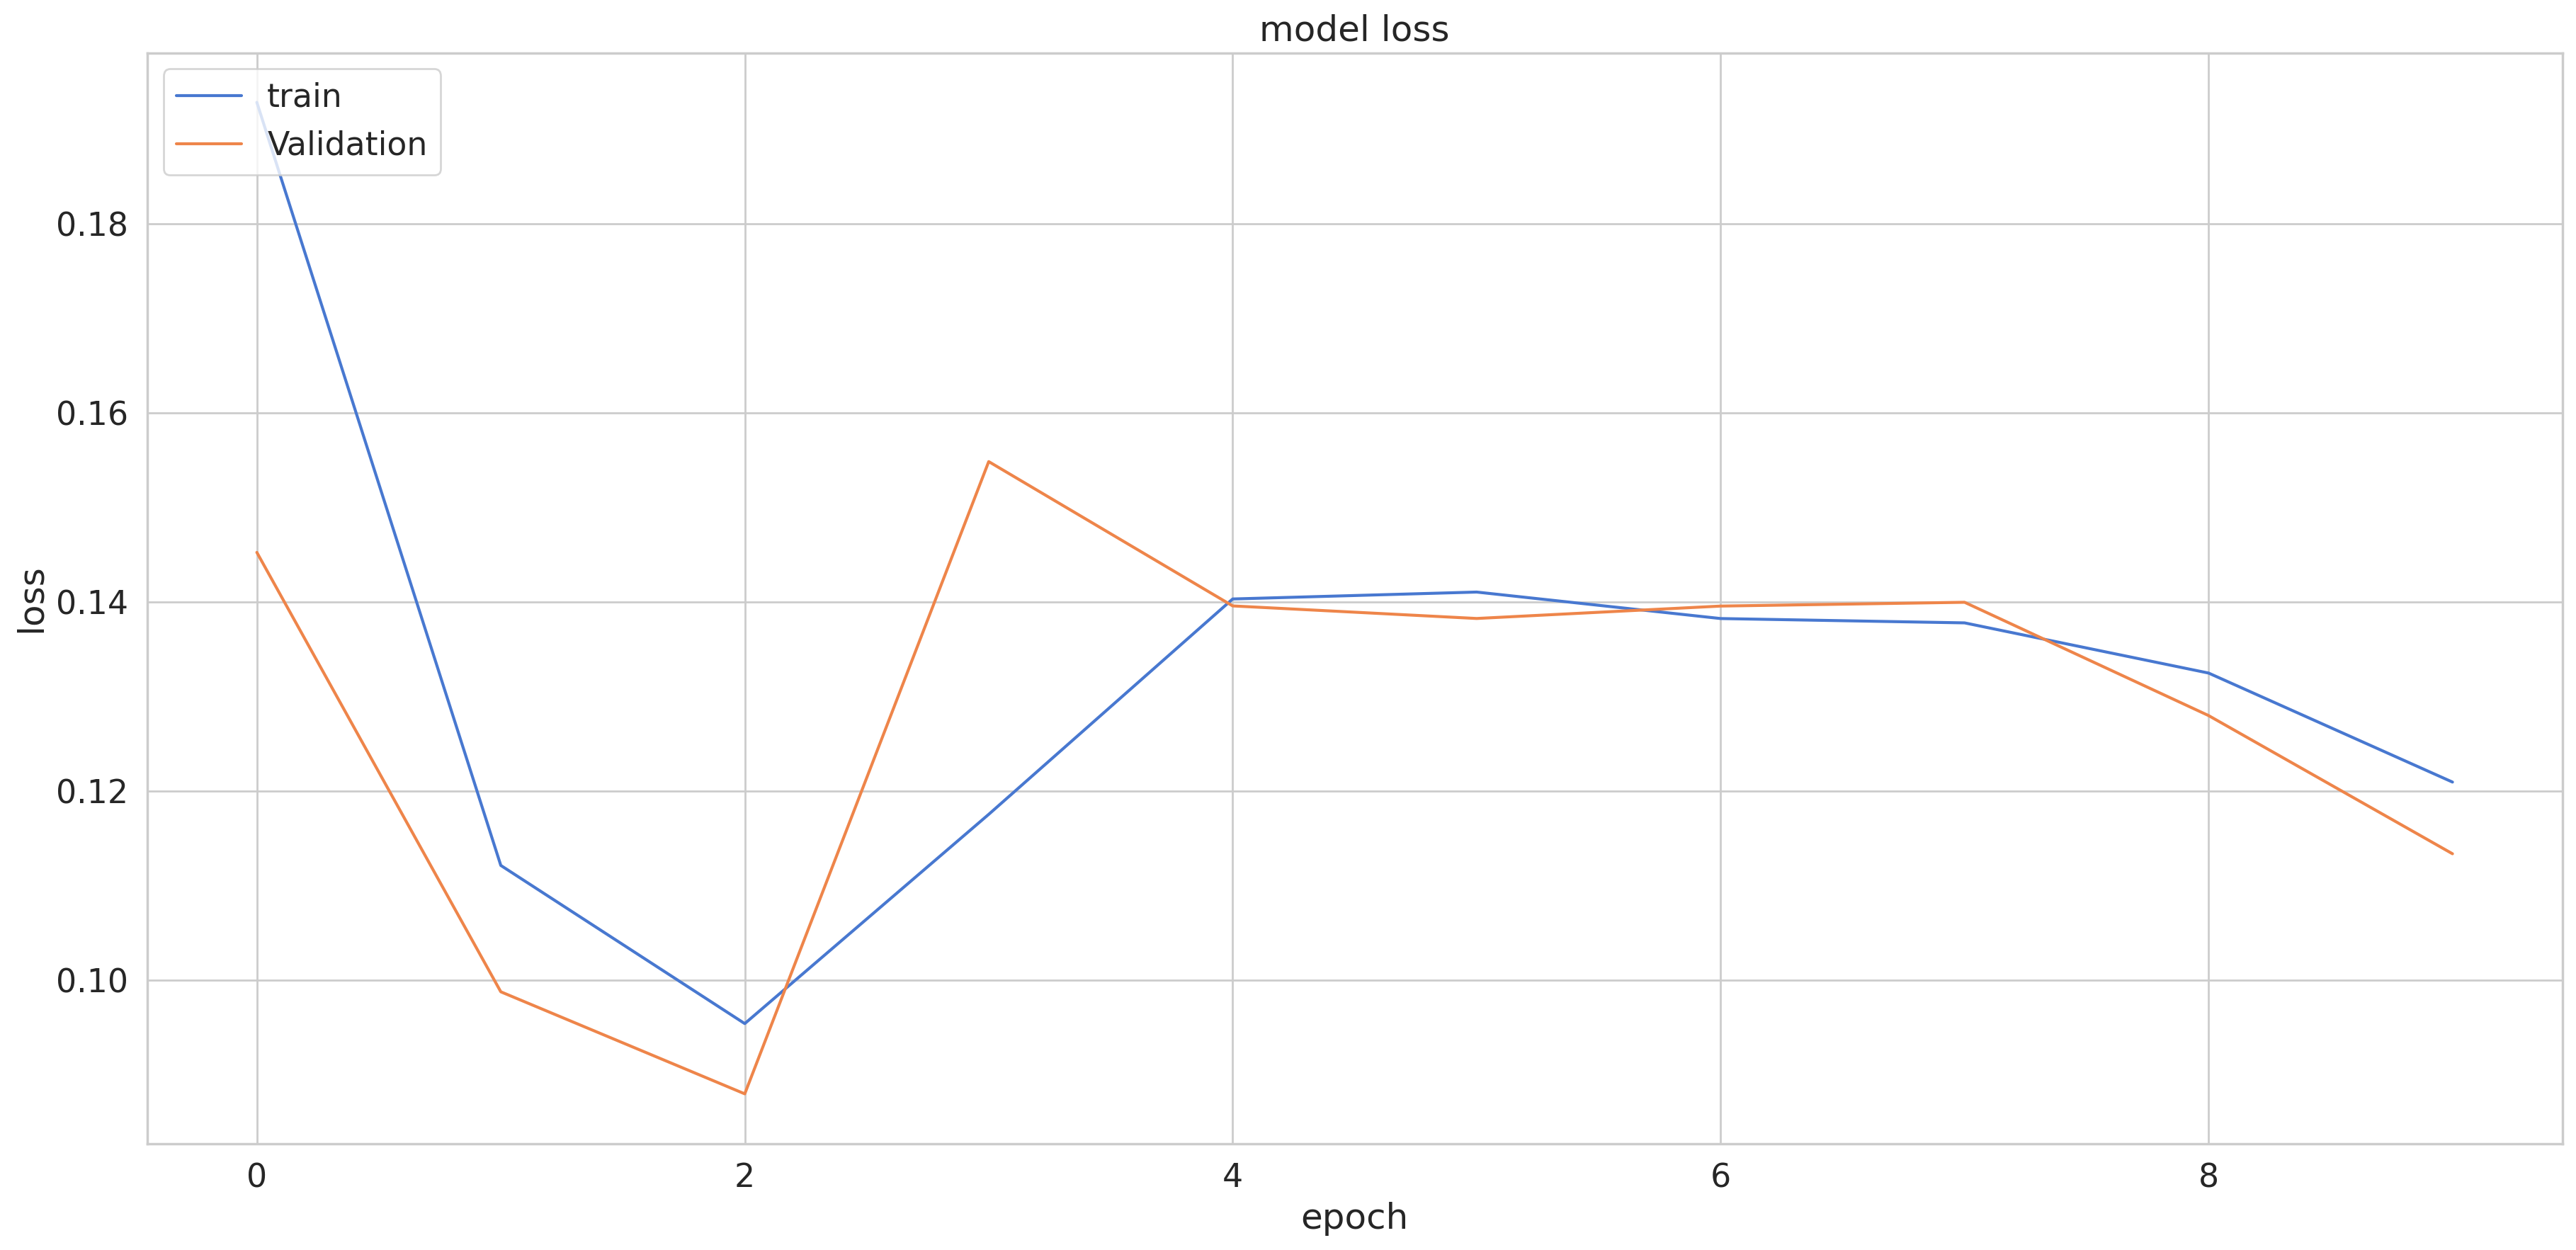

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

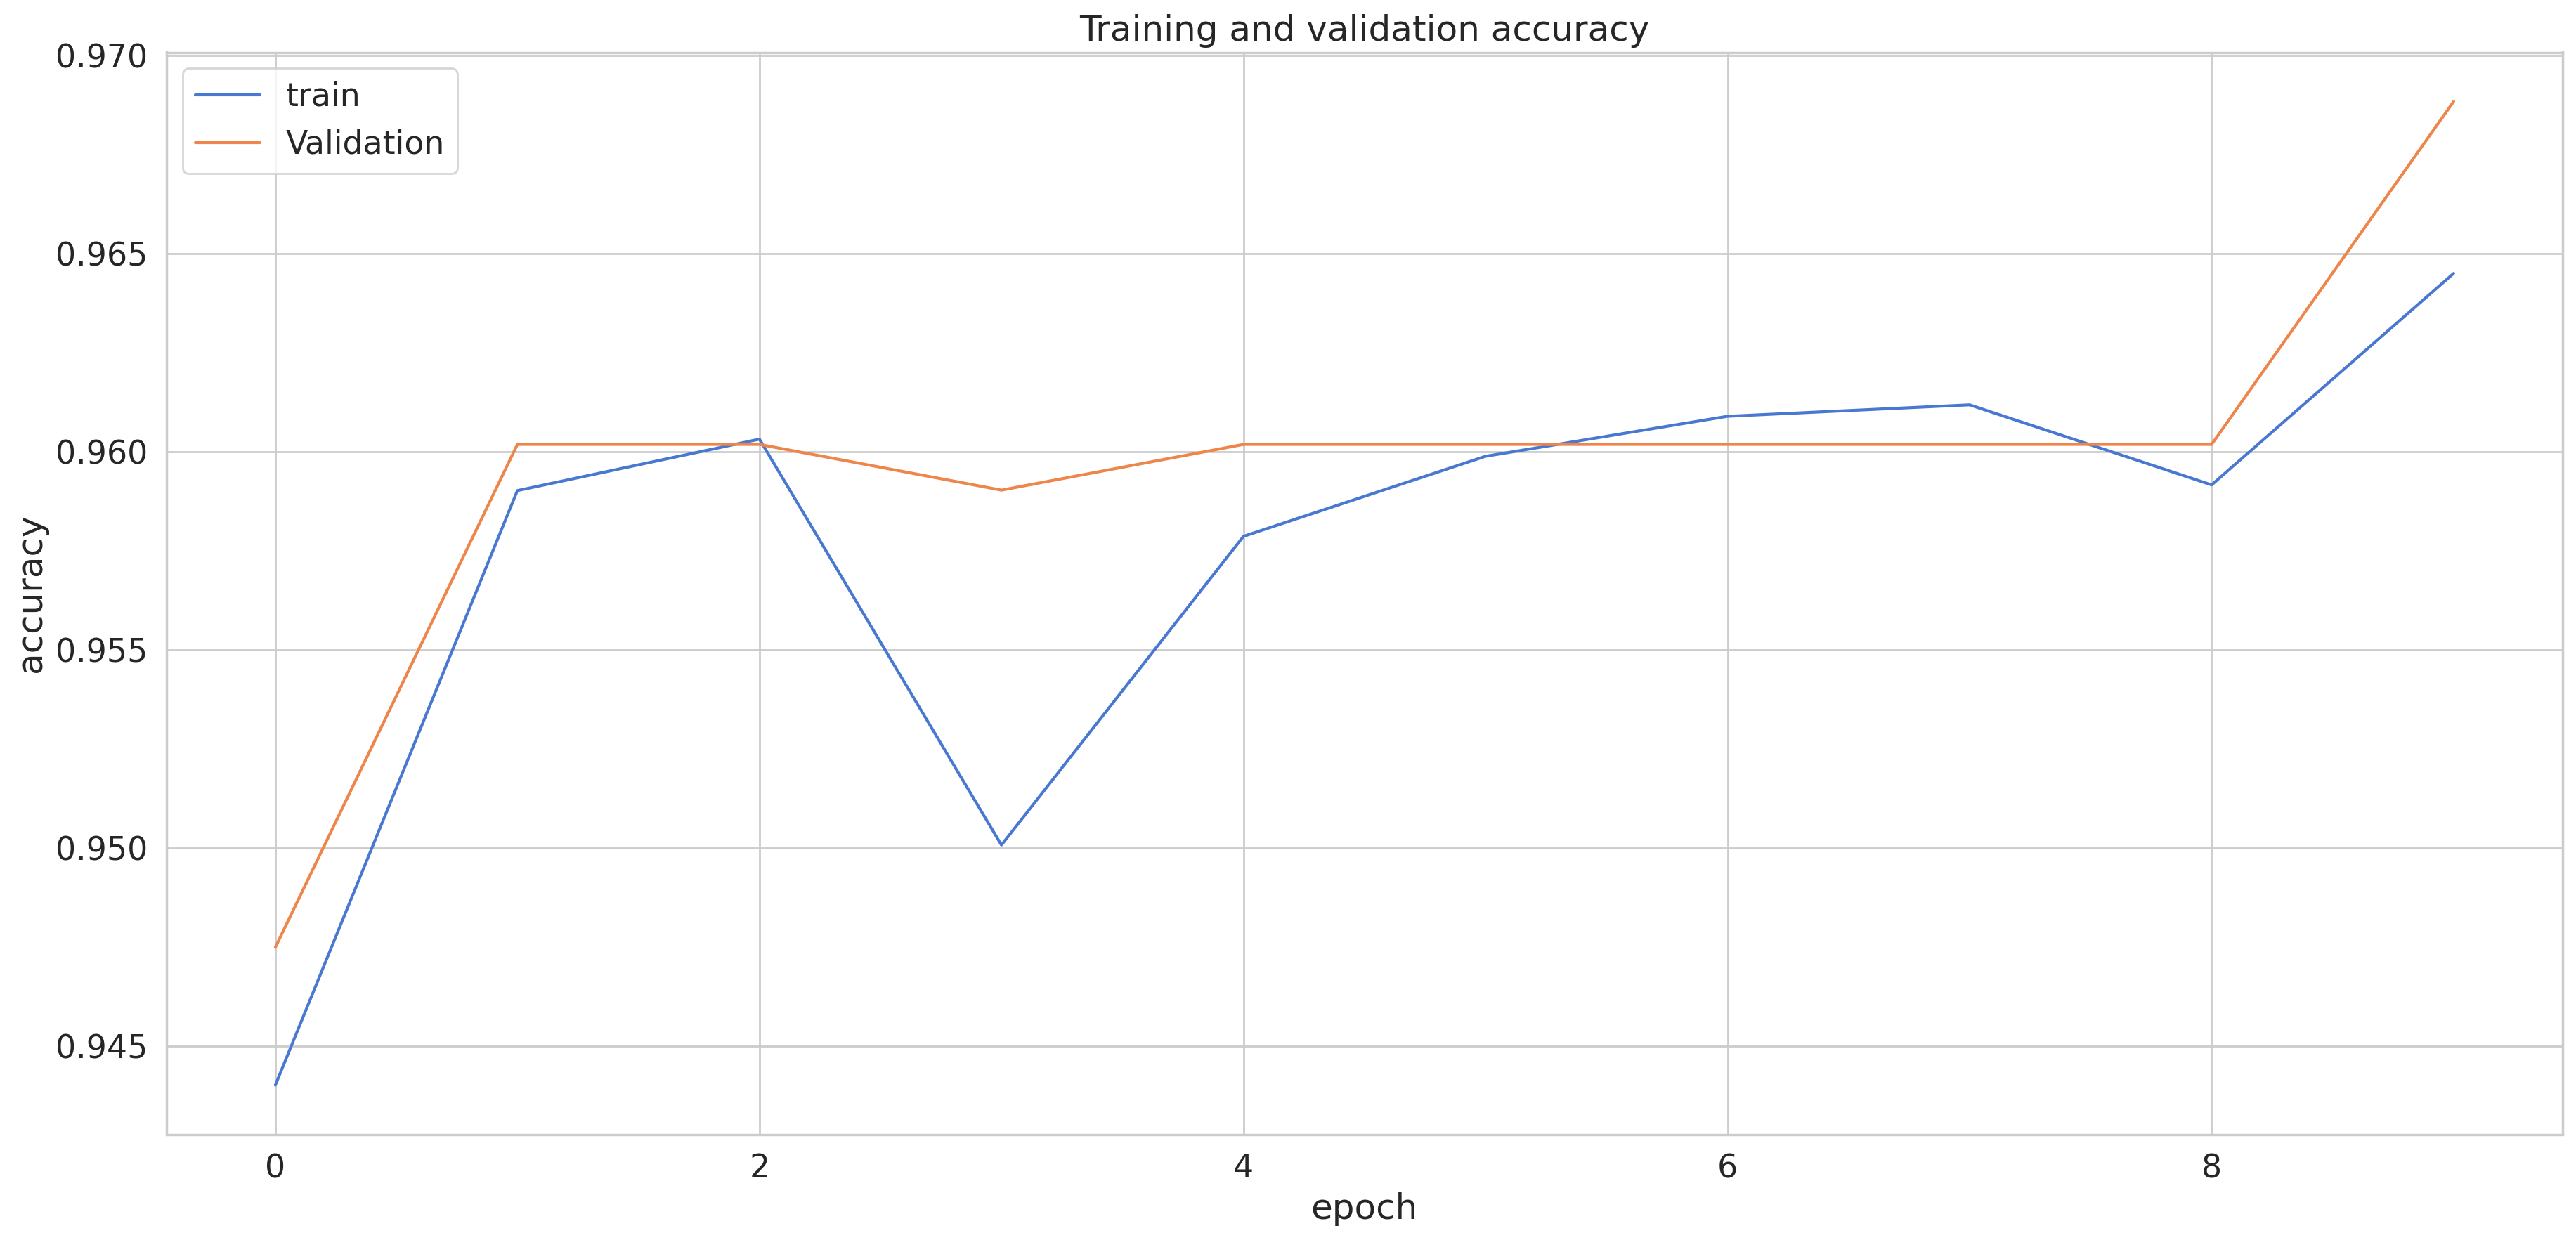

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

68/68 [==============================] - 2s 7ms/step
f1_score =  0.9654545556632878
0.9653739612188366
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1199
           1       0.93      0.99      0.96       967

    accuracy                           0.97      2166
   macro avg       0.96      0.97      0.97      2166
weighted avg       0.97      0.97      0.97      2166



<Axes: >

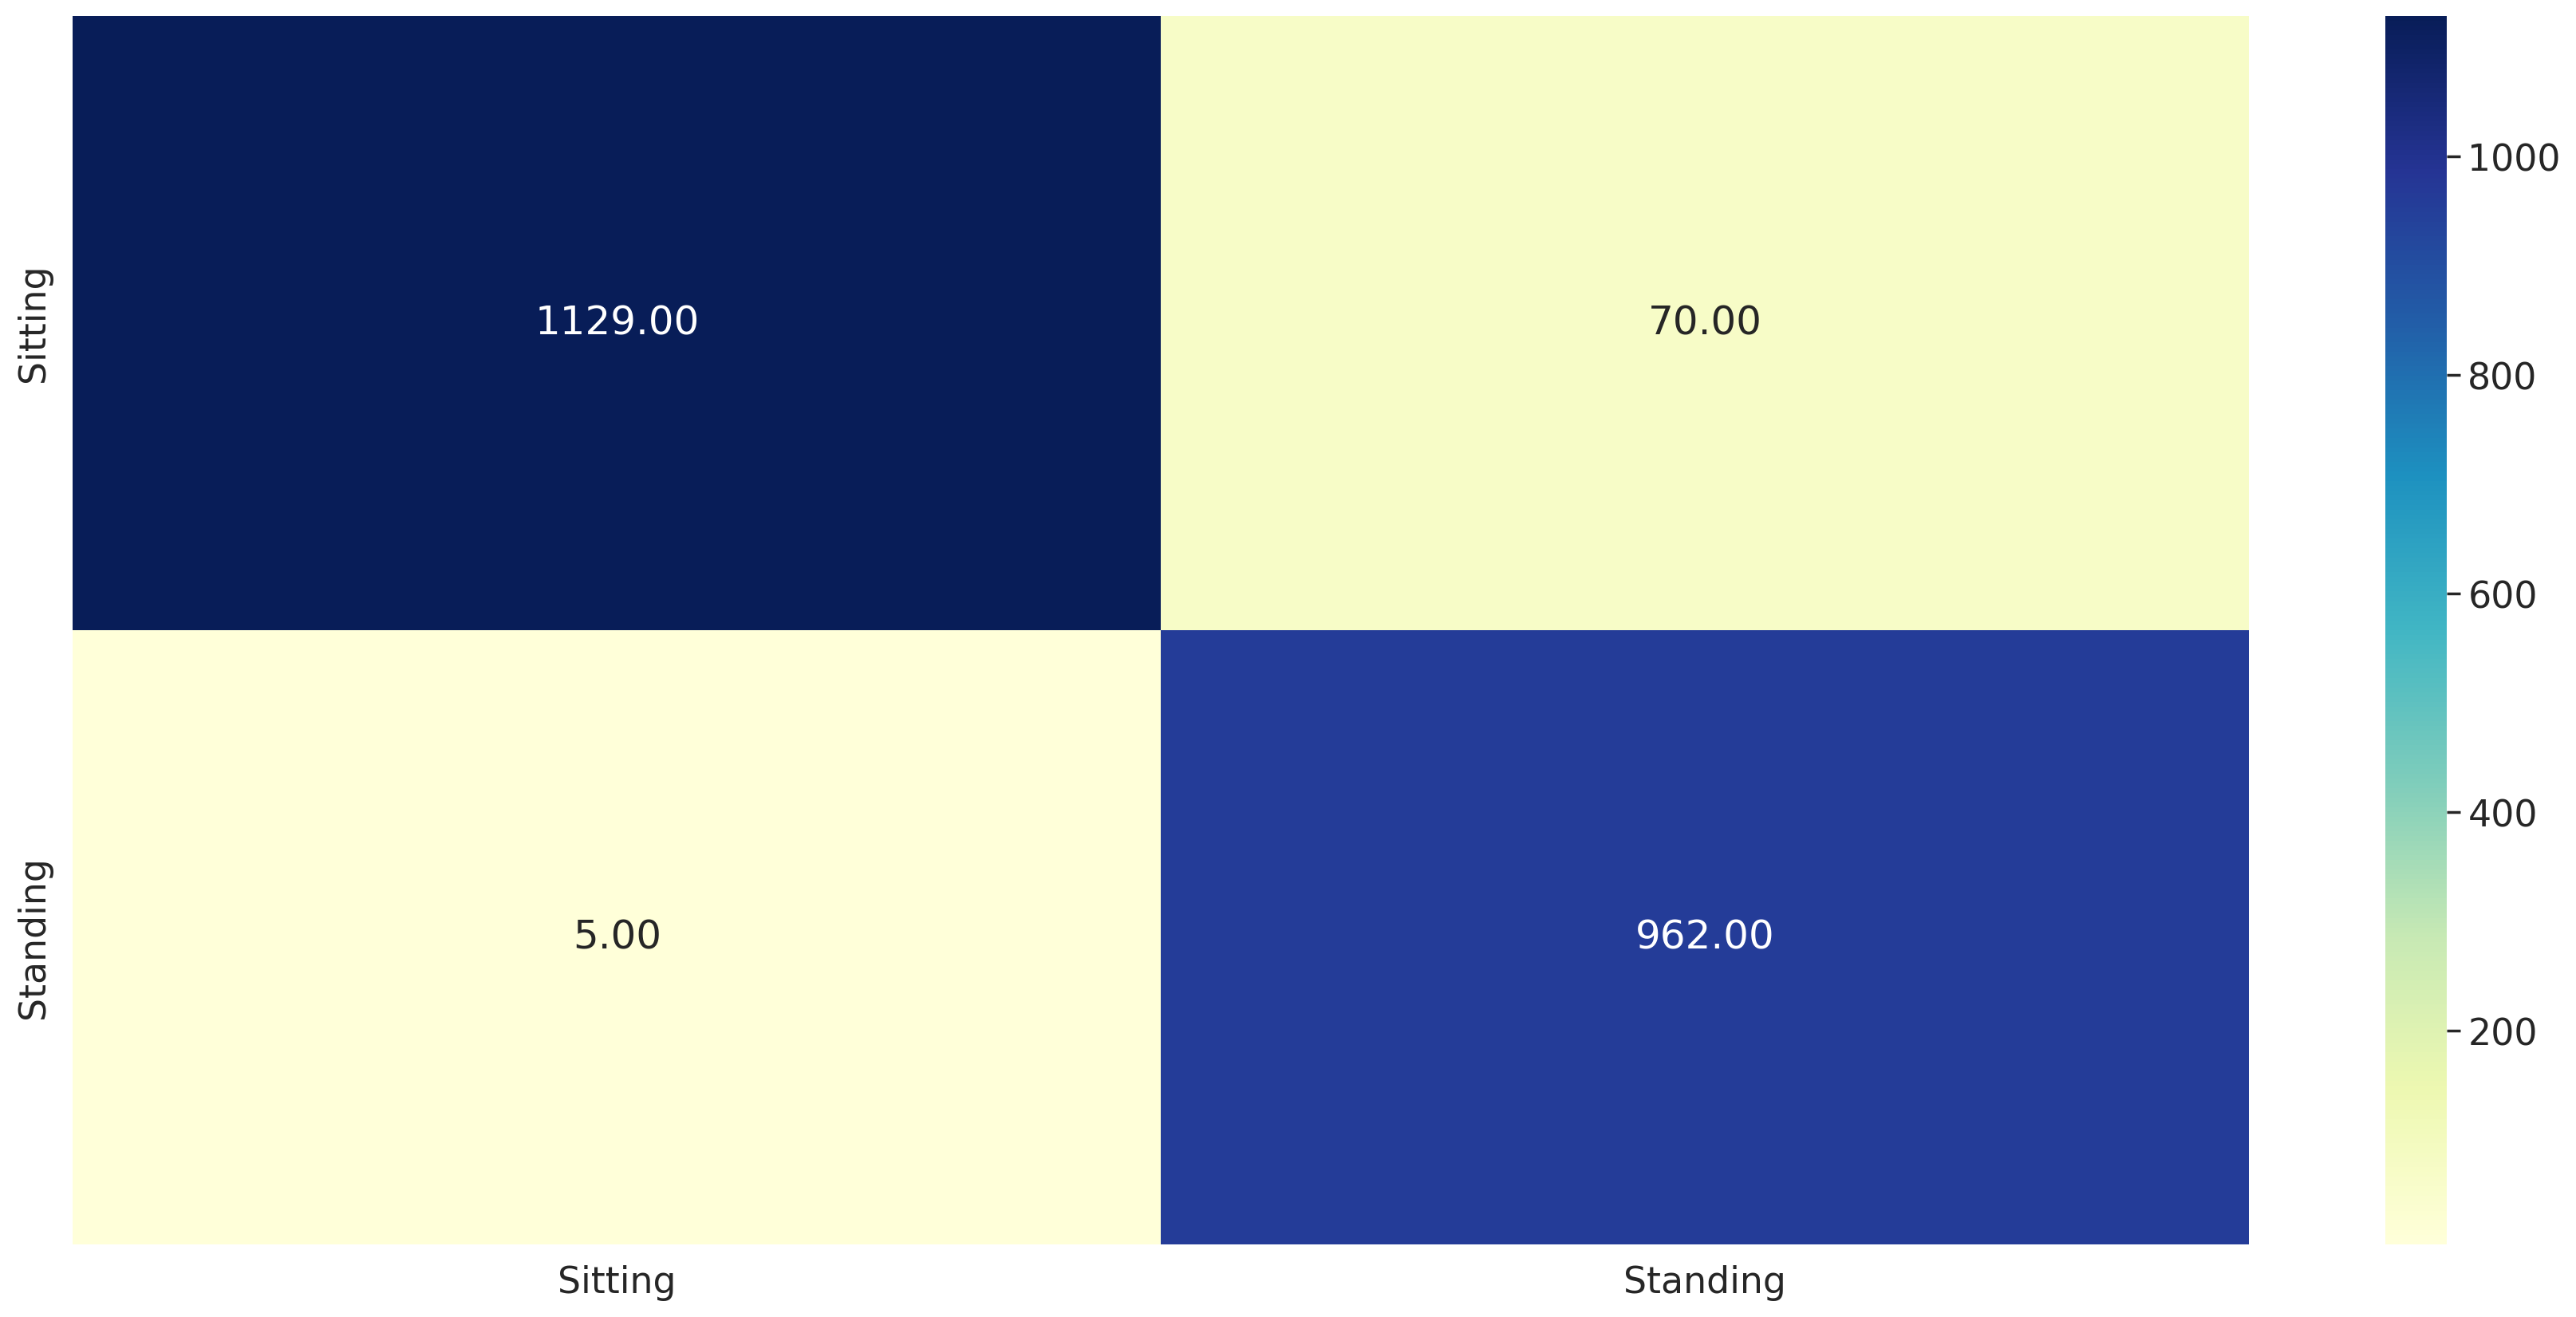

In [19]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = [ 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')